# Operationalizer

**Variables to be operationalized**
- price in USD
- category variable
- ARF (market entry strategy) 
- market exit (deletion of account)
- ARM (time series)
- selling price adjustment (time series)
- proportion of negative feedbacks (time series)


In [2]:
import pandas as pd
import numpy as np

# plotting setup
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from datetime import datetime
import os

## Silkroad2 Item Information

In [3]:
folder = '/Volumes/Extreme SSD/data/final/silkroad2'
file   = 'items.pickle'

df = pd.read_pickle(os.path.join(folder, file))

In [4]:
df['stime_str'] = pd.to_datetime(df.stime_str, format = "%Y-%m-%d").dt.date.astype('datetime64')

In [5]:
df['rtime_dt'] = pd.to_datetime(df['rtime'], unit = 's').dt.date.astype('datetime64')

t_max = df['rtime_dt'].max()
t_min = df['rtime_dt'].min()

print(t_max, t_min)

2015-01-24 00:00:00 2013-11-28 00:00:00


In [6]:
df['flag'] = df.rtime_dt.dt.date
df['vendor'] = df.vendor.str.replace("[0-9]{2}$", "").astype('category')

df = df.drop_duplicates(subset = ['feedback', 'item', 'category', 'rating', 'vendor', 'flag'])
df = df.drop('flag', axis = 1)

In [7]:
s_max = df['stime_str'].max()
s_min = df['stime_str'].min()
s_frq = ((s_max - s_min) / len(df.stime_str.unique())).days

print("The data was collected once every {0} days between {1} and {2}"\
      .format(s_frq, s_min.strftime(format = "%B %d %Y"), s_max.strftime(format = "%B %d %Y")))
print("Within this timespan {0} unique transactions were observed, from a total of {1} unique sellers"\
      .format(len(df), len(df.vendor.unique())))

The data was collected once every 5 days between December 20 2013 and November 06 2014
Within this timespan 2892191 unique transactions were observed, from a total of 1232 unique sellers


## Bitcoin Conversion information

In [8]:
# scrape Bitcoin data
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130429&end=20200212"

bitcoin_data = pd.read_html(url)[2]
bitcoin_data.columns =  map(str.lower, bitcoin_data.columns)

In [9]:
bitcoin_data = bitcoin_data[['date', 'open*', 'high', 'low', 'close**']]\
    .assign(date = pd.to_datetime(bitcoin_data['date']),
            mean = bitcoin_data[['high', 'low']].mean(axis=1))\
    .sort_values('date')\
    .reset_index(drop = True)

# define observation period
observation_period = (bitcoin_data['date'] > t_min)\
                      & (bitcoin_data['date'] < t_max)

max_bit = bitcoin_data[observation_period]['mean'].max()
min_bit = bitcoin_data[observation_period]['mean'].min()

In [10]:
bitcoin_data.head()

date   open*    high     low  close**     mean
0 2013-04-29  134.44  147.49  134.00   144.54  140.745
1 2013-04-30  144.00  146.93  134.05   139.00  140.490
2 2013-05-01  139.00  139.89  107.72   116.99  123.805
3 2013-05-02  116.38  125.60   92.28   105.21  108.940
4 2013-05-03  106.25  108.13   79.10    97.75   93.615

### Fluctiations in bitcoin price

Bitcoin infamously known for its price flucuations. Although the window of observation of this study is way beyond the "bitcoin bubble" occured, there were considerable changes in bitcoin prices overtime.  {{max_bit}}

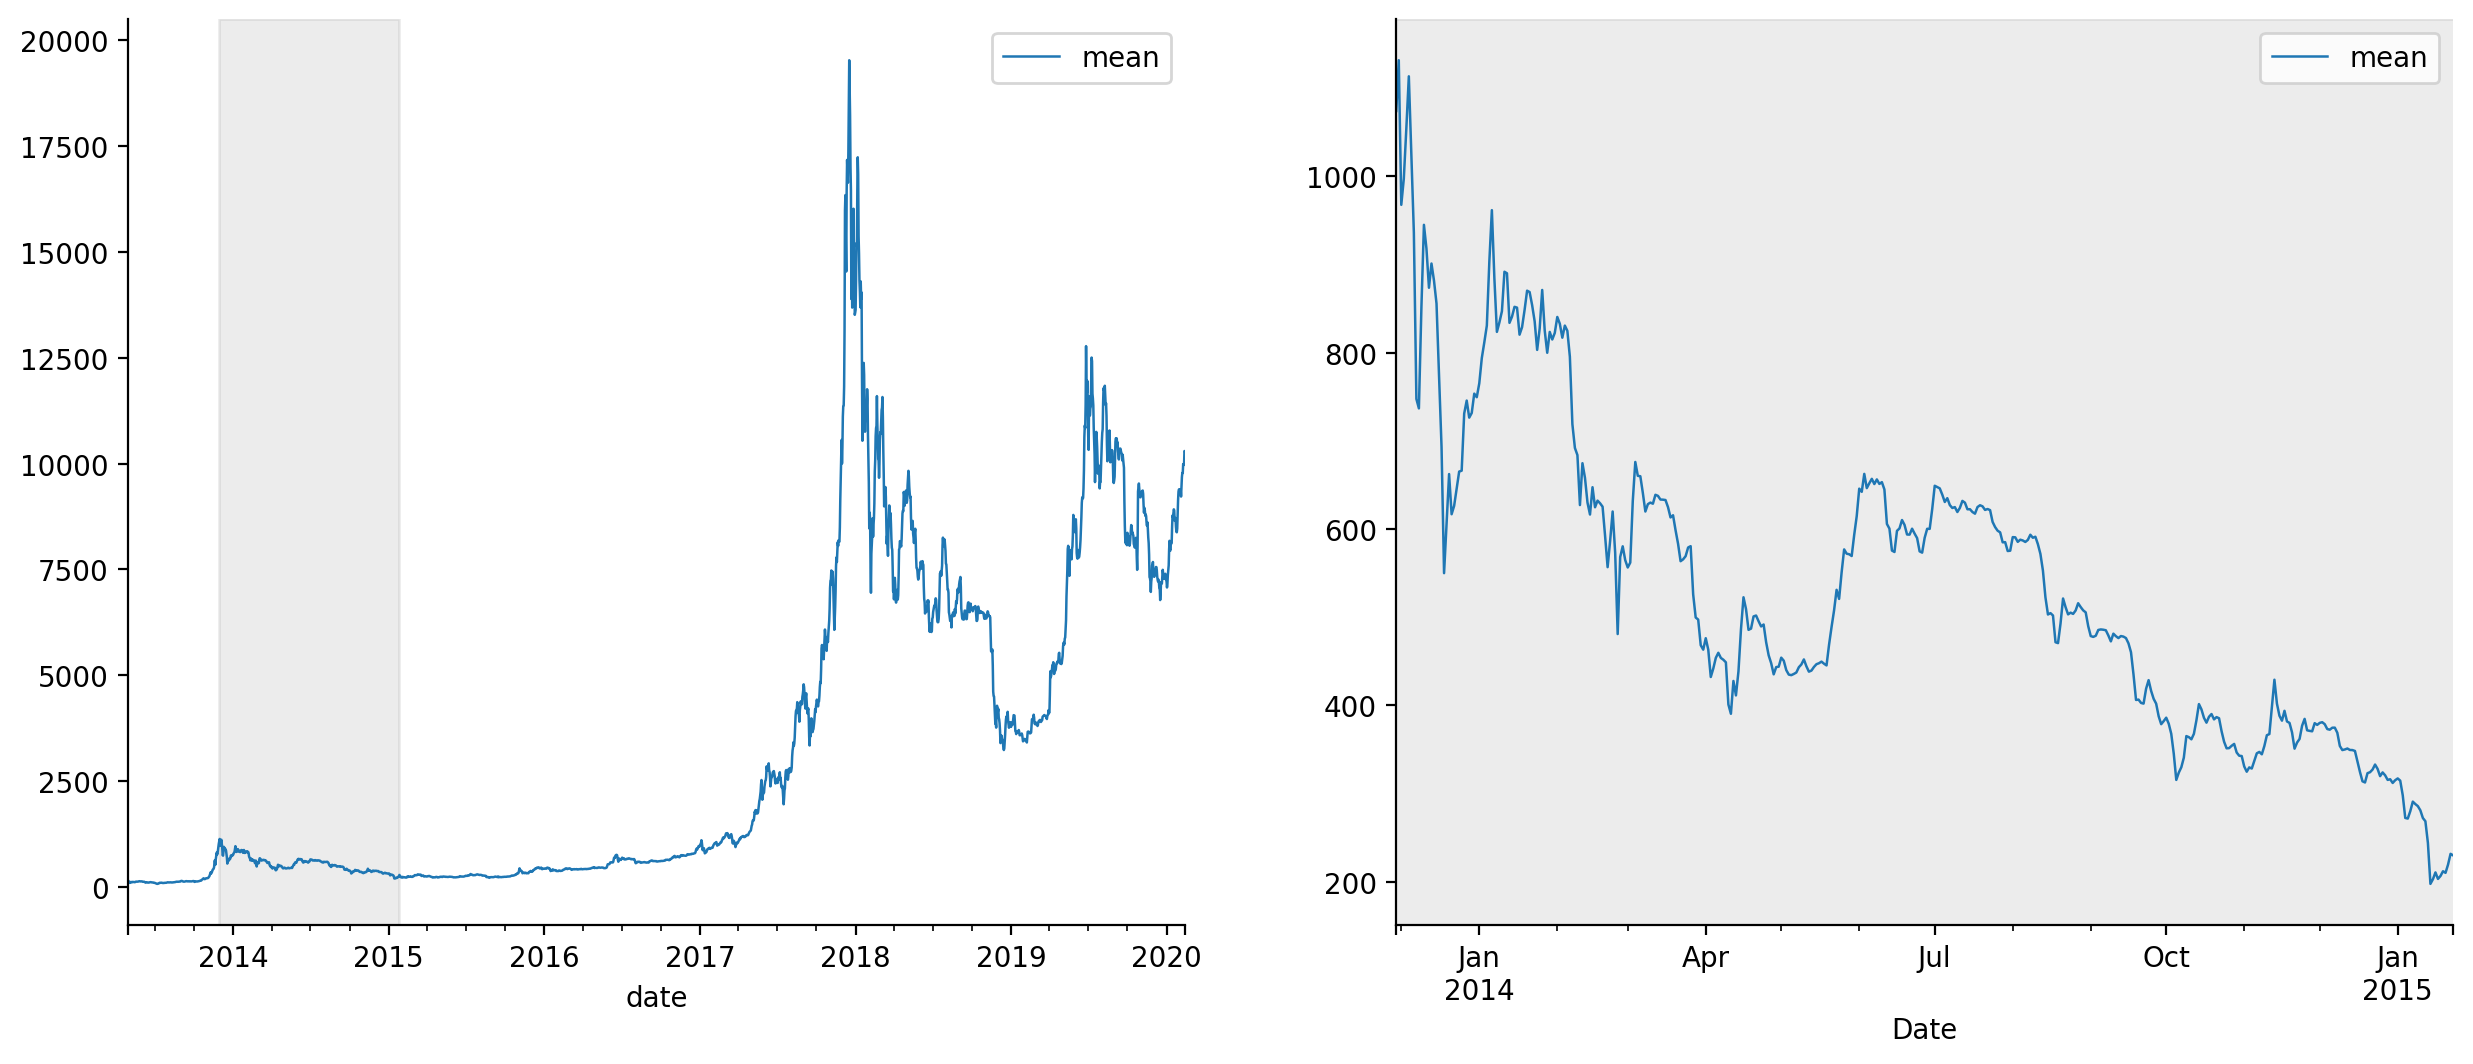

In [11]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 6))

# all time
bitcoin_data.plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax1
)

ax1.axvspan(t_min, t_max, color='grey', alpha=0.15)
ax2.set_xlabel('Date')

# time window of observations
bitcoin_data.loc[observation_period].plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax2
)

ax2.axvspan(t_min, t_max, color='grey', alpha=0.15)
ax2.set_xlabel('Date')

plt.show()

## Converting bitcoin to USD

To make the prices comparable over time points we convert te bitcoin prices to USD. 

In [12]:
# make covertion dictionary
rates = bitcoin_data\
    .assign(date = bitcoin_data['date'])\
    .set_index('date')['mean']\
    .to_dict()

# convert bitcoins to usd
df = df\
    .assign(price_usd = df['rtime_dt'].map(rates) * df['price'])

In [13]:
# assert values are not 'inf'
valid_range = (~df['price_usd'].isin([np.nan, np.inf, -np.inf]))\
               & (df['price_usd'] >= 0)

df['price_usd'] = df['price_usd'].mask(~valid_range)

# mark selling prices higher than 100000 as out of stock
df = df.assign(empty_stock = df['price_usd'] >= 10**4)

604


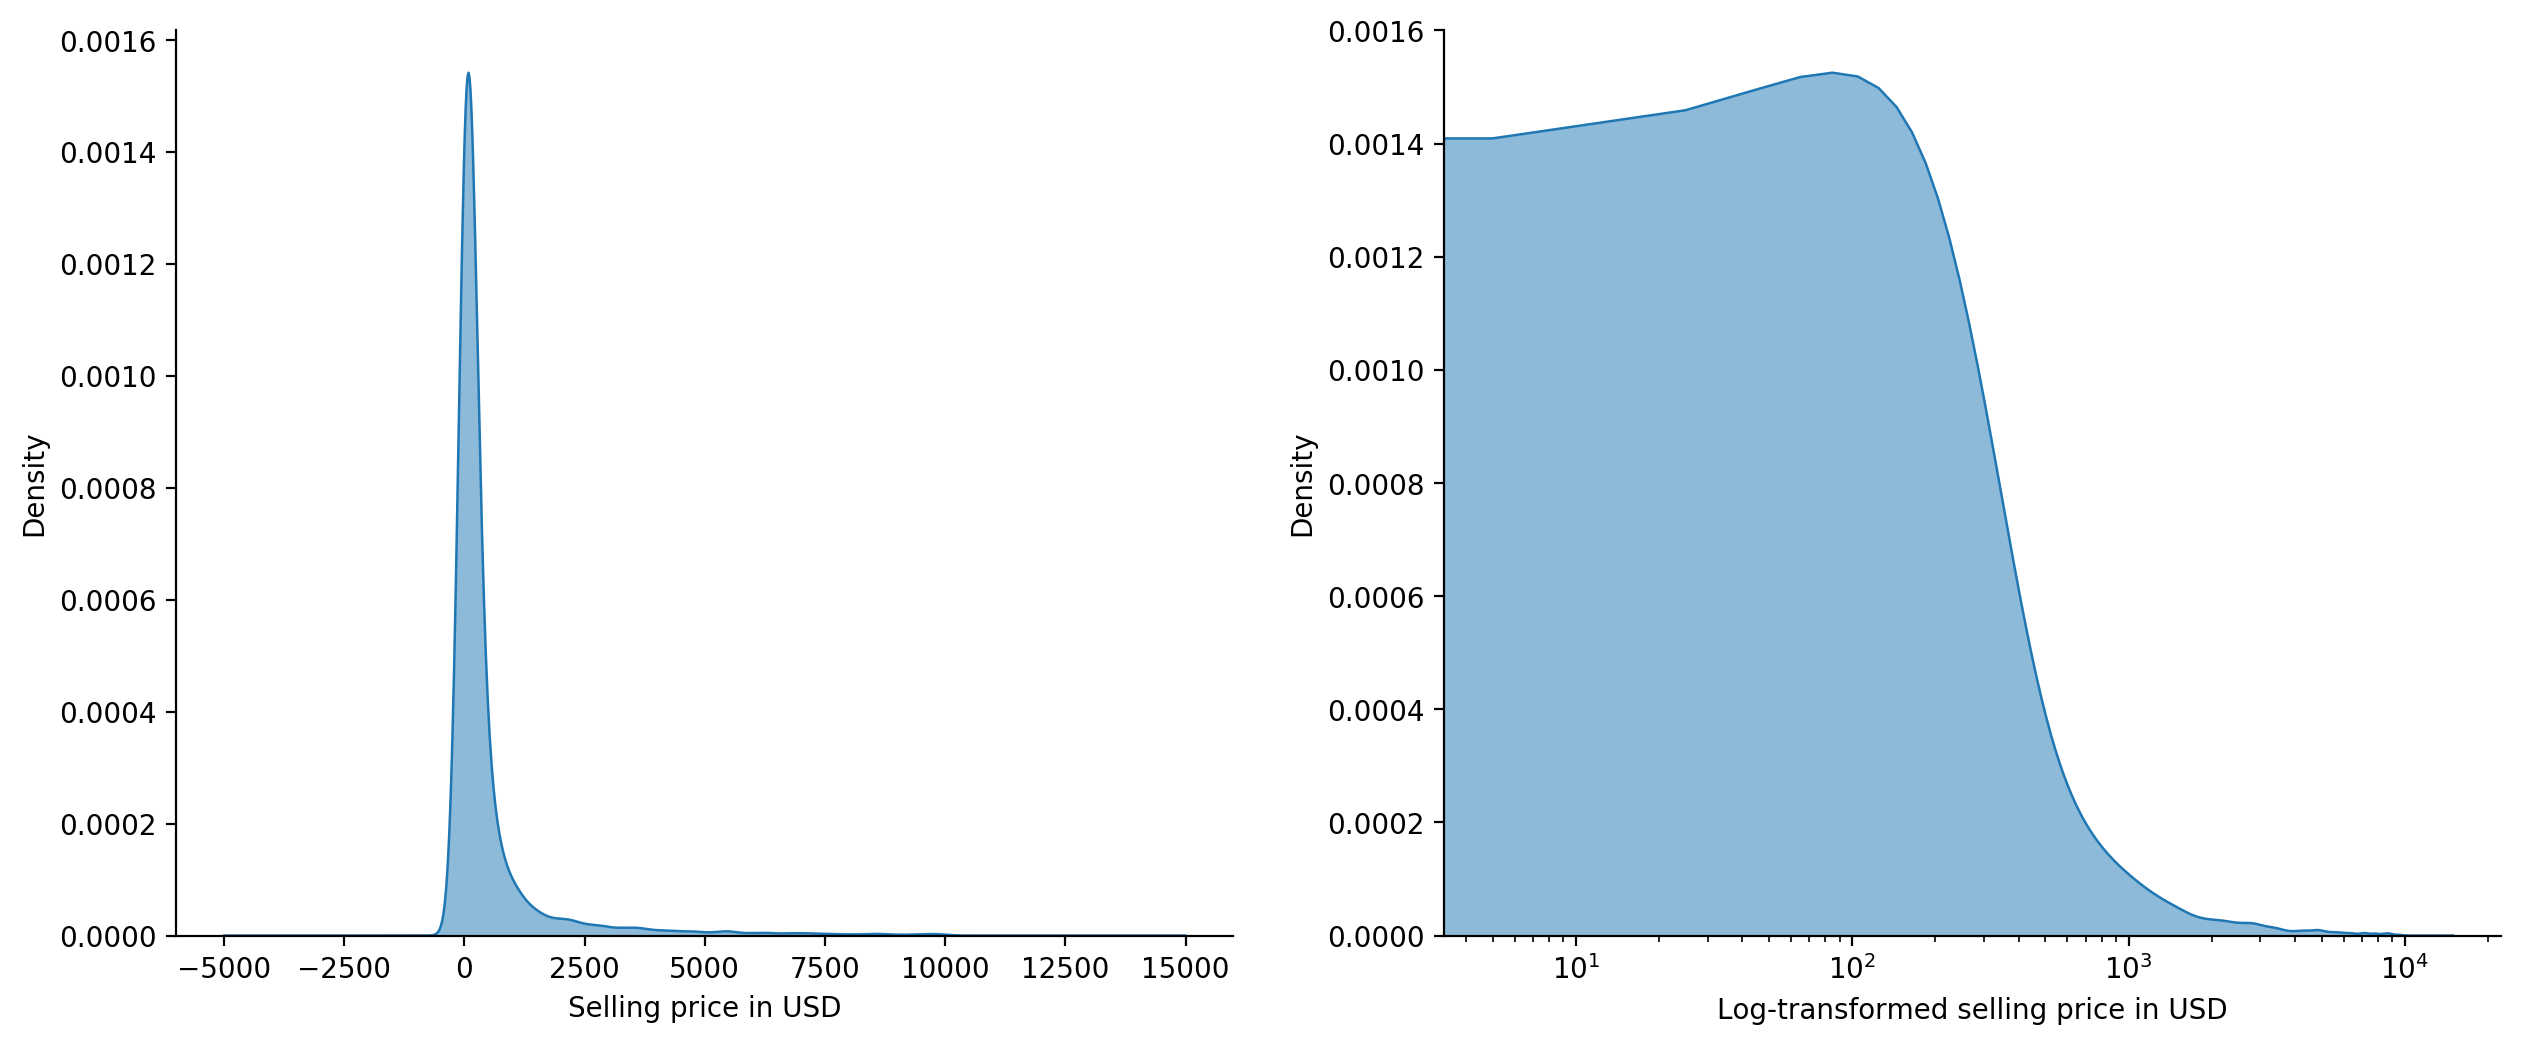

In [14]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

# plot not transformed price (right)
df['price_usd'][valid_range & (df['empty_stock'] == False)]\
    .sample(10000)\
    .dropna()\
    .plot.kde(linewidth = .9, ax = ax1)

# fill density plot (right)
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlabel('Selling price in USD')

# plot log transformed price (left)
df['price_usd'][valid_range & (df['empty_stock'] == False)]\
    .sample(10000)\
    .dropna()\
    .plot.kde(linewidth = .9, ax = ax2)

# fill density plot (left)
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set_xscale('log')
ax2.set_xlabel('Log-transformed selling price in USD')

# asses attriation due to invalid values
k_org = len(df['price_usd'][~df['price_usd'].isin([np.nan, np.inf, -np.inf])])
k_val = len(df['price_usd'][valid_range])
print(k_org - k_val)

plt.show()

The prices of products on *silkroad2* are extremely right skewed. Top tier prices range in USD +100,000. `log`-transformation helps to normalized selling prices considerably. Prices higher than USD 100,000 are considered outliers and are therefore excluded from the data. There by 24497 observations were coded as missing, which can be explained by: 
- missingness on the price variable
- `inf` value on the price value
- missingness on data value

# Rating Time

Rating time (`rtime`) is an instrumental variable to our analysis. Therefore the reliably and quality of this variable is assessed. In our sample a few feedback postings were observed that fall outside of the observation period. These values are backcensored the quality of the data.

In [15]:
print(df[['stime_str', 'rtime_dt']].describe())

t_max = df.stime_str.max()

df['rtime_dt'] = df.rtime_dt.mask((df.rtime_dt - t_max) > pd.Timedelta('0 days')).astype({'rtime_dt' : 'datetime64'})
df = df.dropna().reset_index(drop = True)

                  stime_str             rtime_dt
count               2892191              2892191
unique                   57                  422
top     2014-08-27 00:00:00  2014-06-09 00:00:00
freq                 282028                77145
first   2013-12-20 00:00:00  2013-11-28 00:00:00
last    2014-11-06 00:00:00  2015-01-24 00:00:00


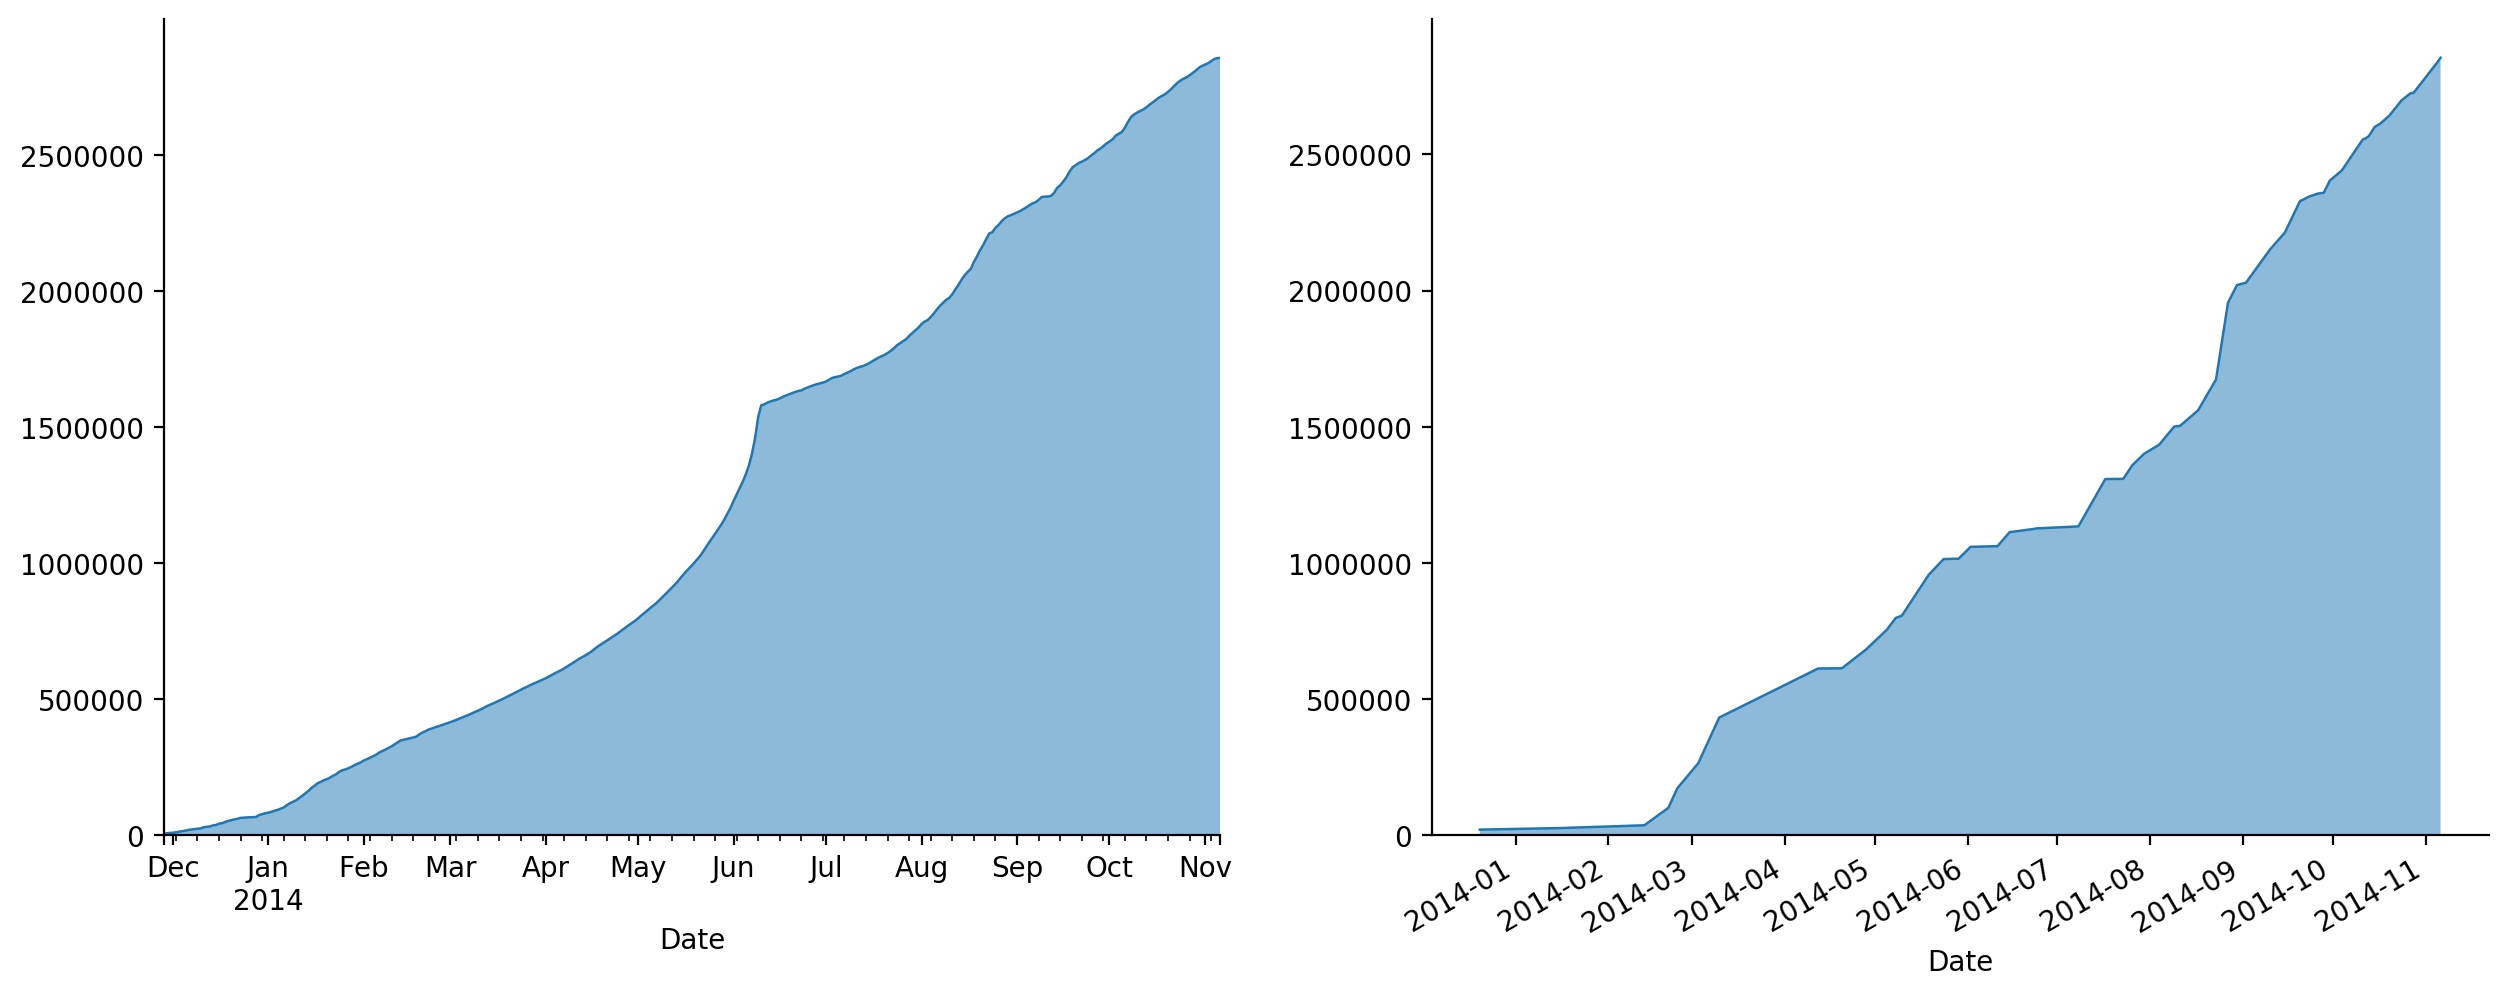

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

#make cum_dist plot rating time (left)
df\
    .groupby('rtime_dt')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax1, linewidth = .9)
ax1.set_ylim(bottom = 0)

#fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlabel('Date')


# make cum_dist plot scrape time (right)
df\
    .groupby('stime_str')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax2, linewidth = .9)
ax2.set_ylim(bottom = 0)

#fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set_xlabel('Date')

plt.show()

The plots above show the cumulative distribution of sample size by rating time (left: `rtime`) and scrape time (right: `stime`). 

#### Cumulative distribution of feedback postings
The left subplot show that the feedbacks posted in our sample are posted gradually over time. This reflects a natural growth distribution of feedback postings in the collected sample. This indicates that the scraping process of the data has proceeded quite reliably. 

#### Cumulative sample size make up per scrape
On the right subplot shows an increasing growth of sample size, which is an inherent characteristic of scraped data. Scrapes at later time points might collect data points that were overlooked in previous scrapes. 

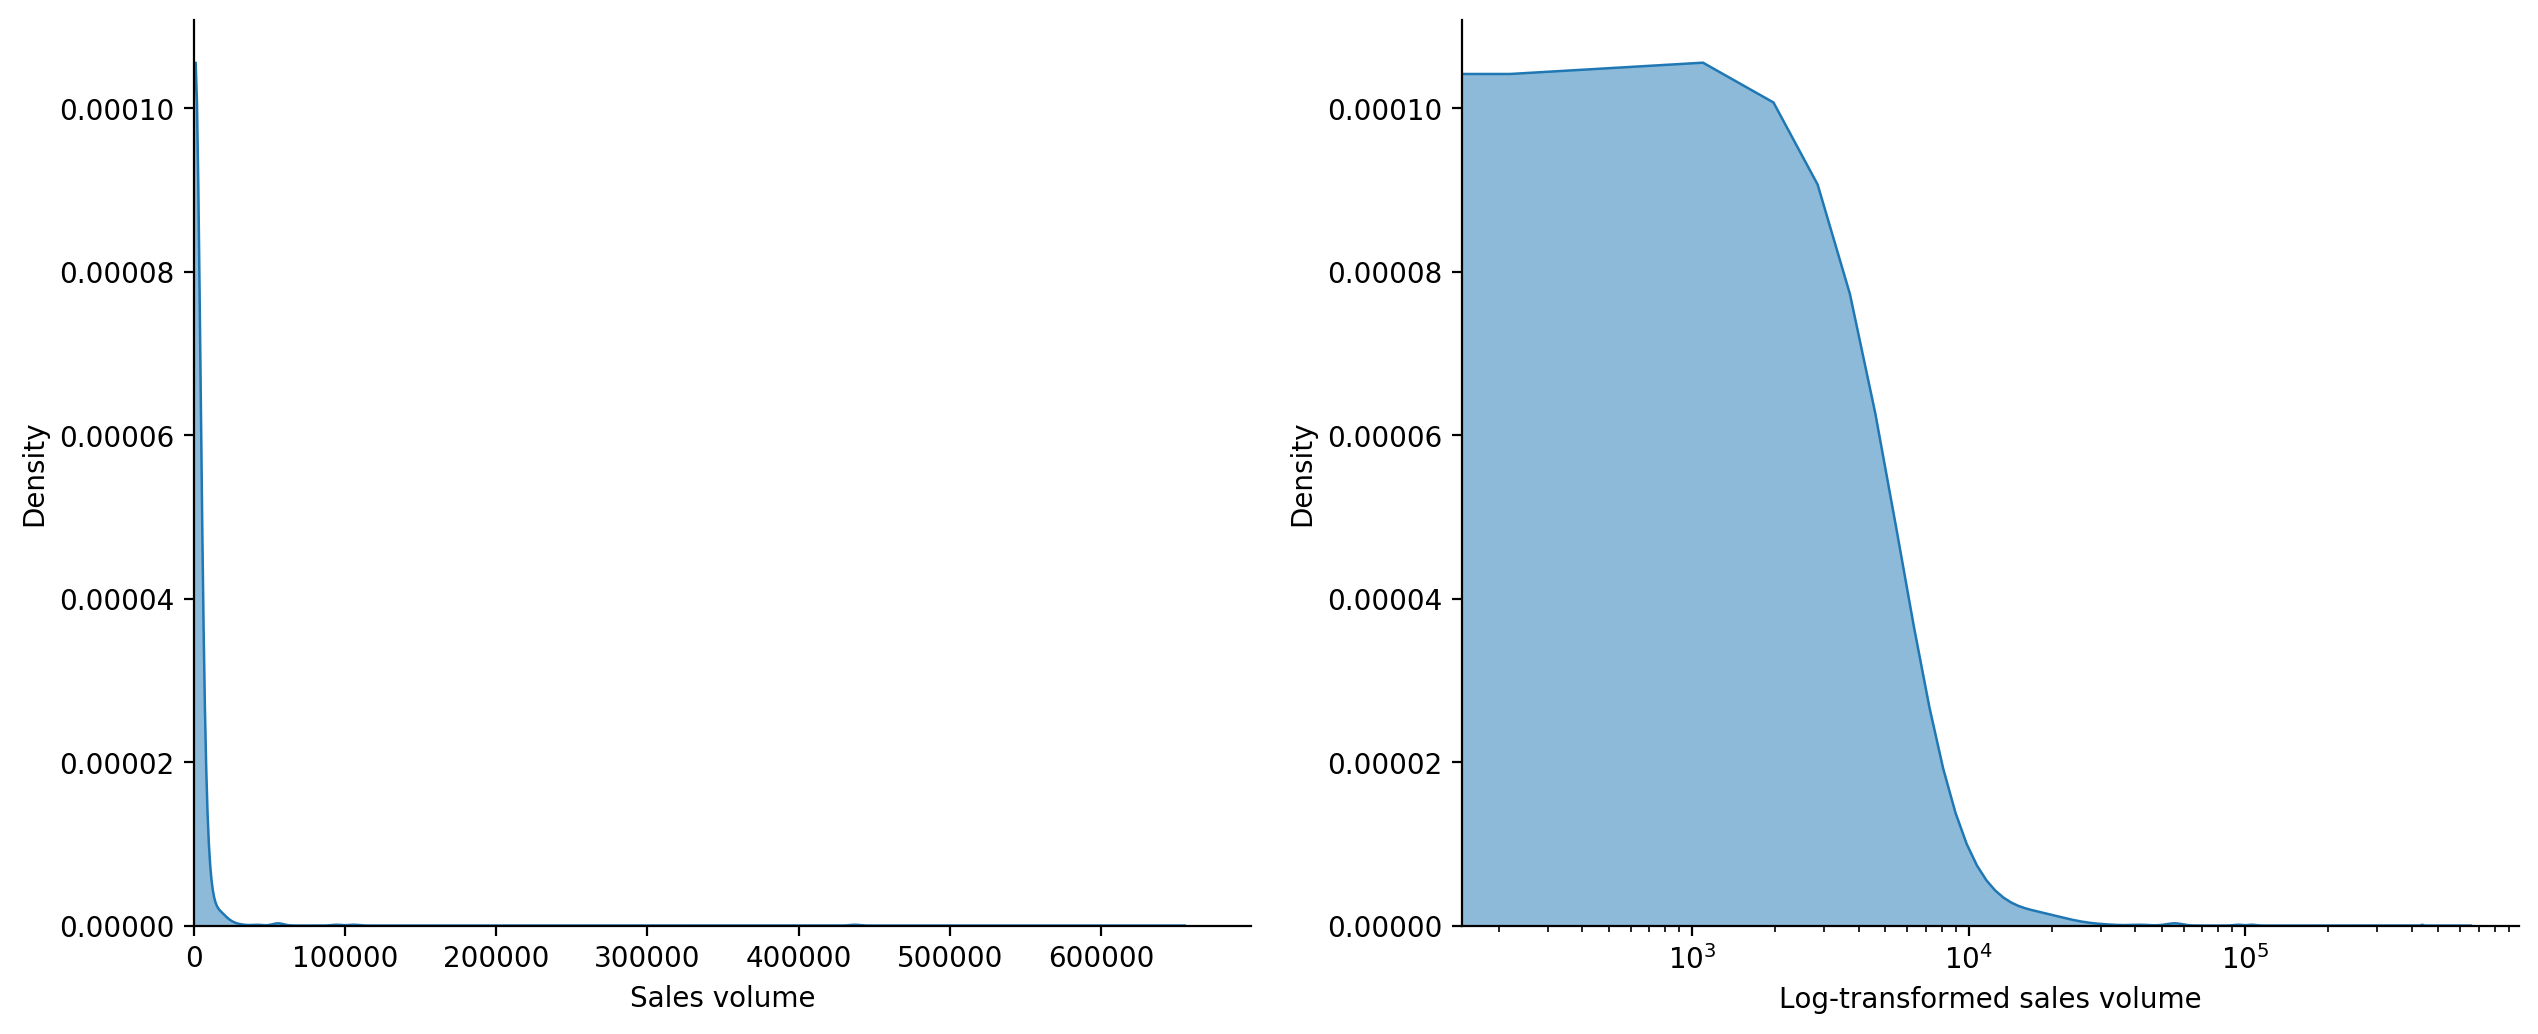

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# plots density distribution for sale volume (left)
df['vendor'].value_counts().plot.kde(ax = ax1, linewidth = .9)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = -50)
ax1.set(xlabel = 'Sales volume')

# plots density distribution for log-transformed sales volume (right)
df['vendor'].value_counts().plot.kde(ax = ax2, linewidth = .9)
ax2.set_xscale('log')

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set(xlabel = 'Log-transformed sales volume')

plt.show()

# Time of feedback posting

In [18]:
# create time difference between sales for sellers
df = df.sort_values('rtime_dt')
df['t'] = df\
    .assign(rtime_dt = df['rtime_dt'])\
    .groupby('vendor')['rtime_dt']\
    .transform(lambda x: (x - x.min()).dt.days)


# creates time variables for sellers
df = df.sort_values(['vendor', 'rtime_dt'])
df['count'] = df.groupby(['vendor']).cumcount()
df = df.sort_values(['vendor', 'rtime_dt'])
df['cum_count'] = df.groupby('vendor')['vendor'].transform(np.size)

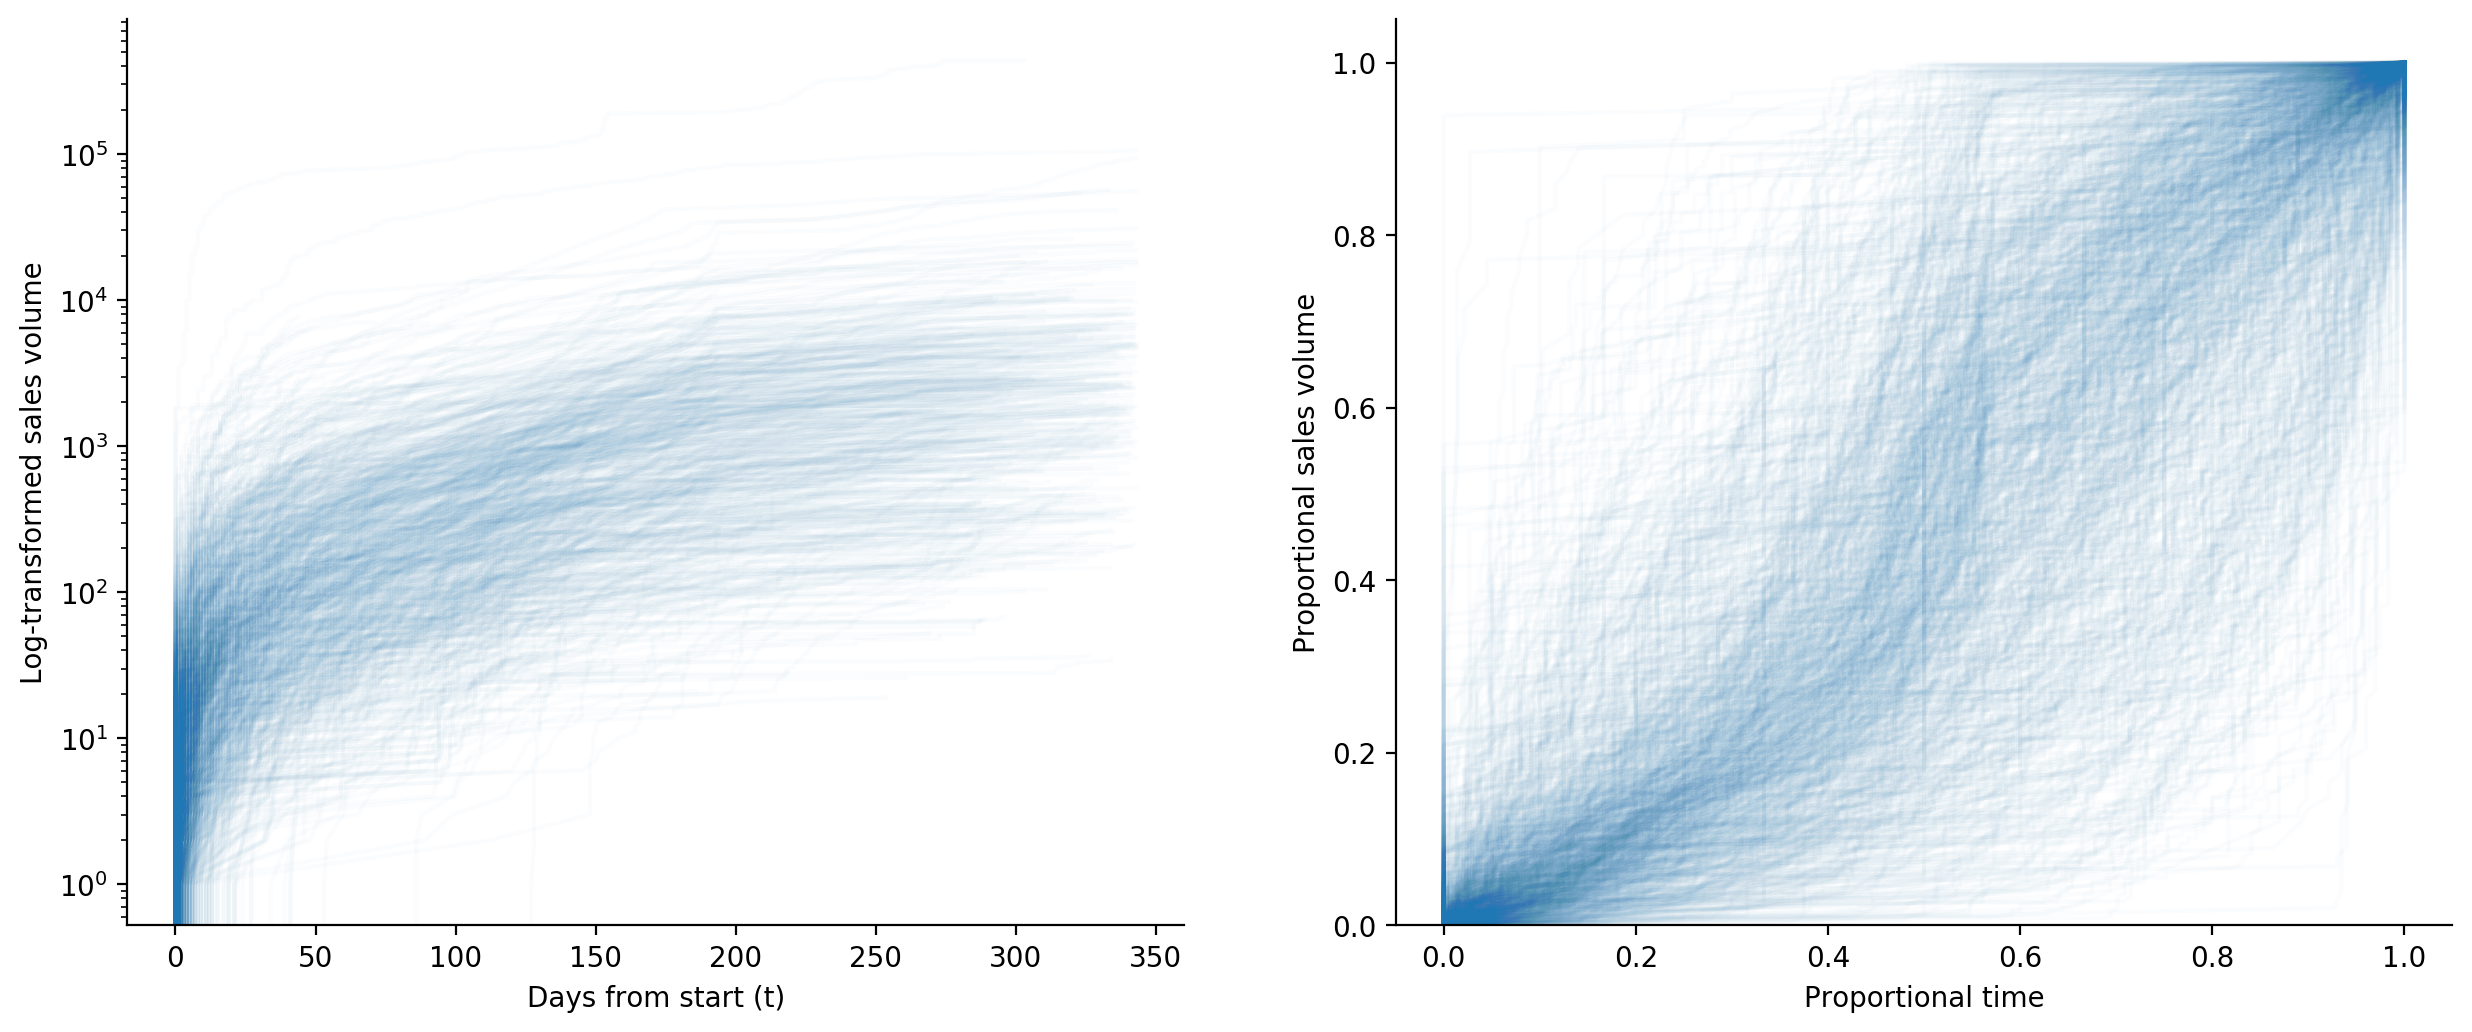

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# getting sellers that have had sufficient number of sales
df_ = df[df['cum_count'] >= 20]

vendors = df_['vendor'].unique().tolist()

# iterative plotting for sales trajectory per cryptoseller
for vendor in vendors:
    v = df_[df_['vendor'] == vendor][['count', 't']].dropna()
    y = v['count'].astype(int).sort_values()
    x = v['t'].astype(int).sort_values()
    
    # plots sales trajectory sellers (left)
    ax1.plot(x, y, alpha = .02, c = '#1f77b4')
    ax1.set_yscale('log')
    ax1.set(xlabel = 'Days from start (t)',
            ylabel = 'Log-transformed sales volume')
    
    y = y / v['count'].max().astype(int)
    x = x / v['t'].max().astype(int)
    
    # plots proportional graph (right)
    ax2.plot(x, y, alpha = .02, c = '#1f77b4')
    ax2.set_ylim(bottom = 0)
    ax2.set(xlabel = 'Proportional time',
            ylabel = 'Proportional sales volume')

# display plot
plt.show()

The graphs above displays the cumulative sales over time for each seller that had more than 20 sales in the observed period. The left panel displays the logmarithmically transformed sales trajectories over time. The right panel shows the proportional increase in sales over the proportion of time that the seller as pressent on the market. 

## Artificial Reputation Formation

In [20]:
def f(x):
    x['diff'] = x['t']-x['t'].shift(1)
    return x

df = df.sort_values(['vendor', 't'])

# calculates time difference between sales
df['diff'] = df\
    .groupby('vendor')\
    .apply(f)['diff']\
    .fillna(1)\
    .sort_index()

# drop existing column
if 'delta_t' in df:
    df = df.drop('delta_t', axis = 1)

# creates look-up table with delta_t column
df = df.sort_values(['vendor', 't'])
col = df['diff']\
    .groupby([df['vendor'], df['t']])\
    .apply(lambda x: x.mean())\
    .reset_index()\
    .rename(columns = {'diff' : 'delta_t'})
    
# merges delta_t on dataframe
df = pd.merge(df, col, on = ['vendor', 't'])

In [21]:
df.sample(5)

vendor         stime   stime_dt  stime_str  rating  \
1586770          drpsych  1.409122e+09 2014-08-27 2014-08-27       5   
2409117    profesorhouse  1.411180e+09 2014-09-20 2014-09-20       5   
641155   Liveincontainer  1.402430e+09 2014-06-10 2014-03-10       5   
884035       PurpleLotus  1.402430e+09 2014-06-10 2014-02-24       5   
2194750    profesorhouse  1.402431e+09 2014-06-10 2014-05-19       5   

                                                  feedback  \
1586770  Fucking idiot. Stealth idea of a 3 year old. P...   
2409117                                              works   
641155   so everyone mentioning the awesome stealth was...   
884035   Purple Durple Lotus is THE MAN. These coupon p...   
2194750        Everything came as described with no delay.   

                                                      item  \
1586770  ╚»★ MODAFINIL MODALERT 200 mg 500 pills - Free...   
2409117  Facebook , youtube , twitter , instagram services   
641155                                2C-B HCl powder - 1g   
884035   The Original Lotus Coupon Collection (O.C.) S....   
2194750          5 Unique Methods $5k+day BlackhatWhitehat   

                                category     price  freshness  ...   rtime_dt  \
1586770    drugs-prescription-stimulants  0.808314         64  ... 2014-06-24   
2409117  drugs-other-intoxicants-alcohol  1.050000          2  ... 2014-09-18   
641155       drugs-psychedelics-2cfamily  0.143720         71  ... 2014-03-31   
884035                         forgeries  0.153385         27  ... 2014-05-14   
2194750  drugs-other-intoxicants-alcohol  1.906405          2  ... 2014-06-08   

              location           area    price_usd  empty_stock    t   count  \
1586770          India      Worldwide   476.634490        False  162    1171   
2409117        Belgium     Undeclared   456.728979        False  254  363137   
641155          Norway      Worldwide    66.569667        False  117     466   
884035   United States  United States    68.038518        False  166    2620   
2194750        Belgium     Undeclared  1250.935283        False  152  148770   

         cum_count  diff   delta_t  
1586770       1675   0.0  0.250000  
2409117     436934   0.0  0.000078  
641155        1671   0.0  0.166667  
884035        5021   0.0  0.047619  
2194750     436934   0.0  0.000070  

[5 rows x 21 columns]

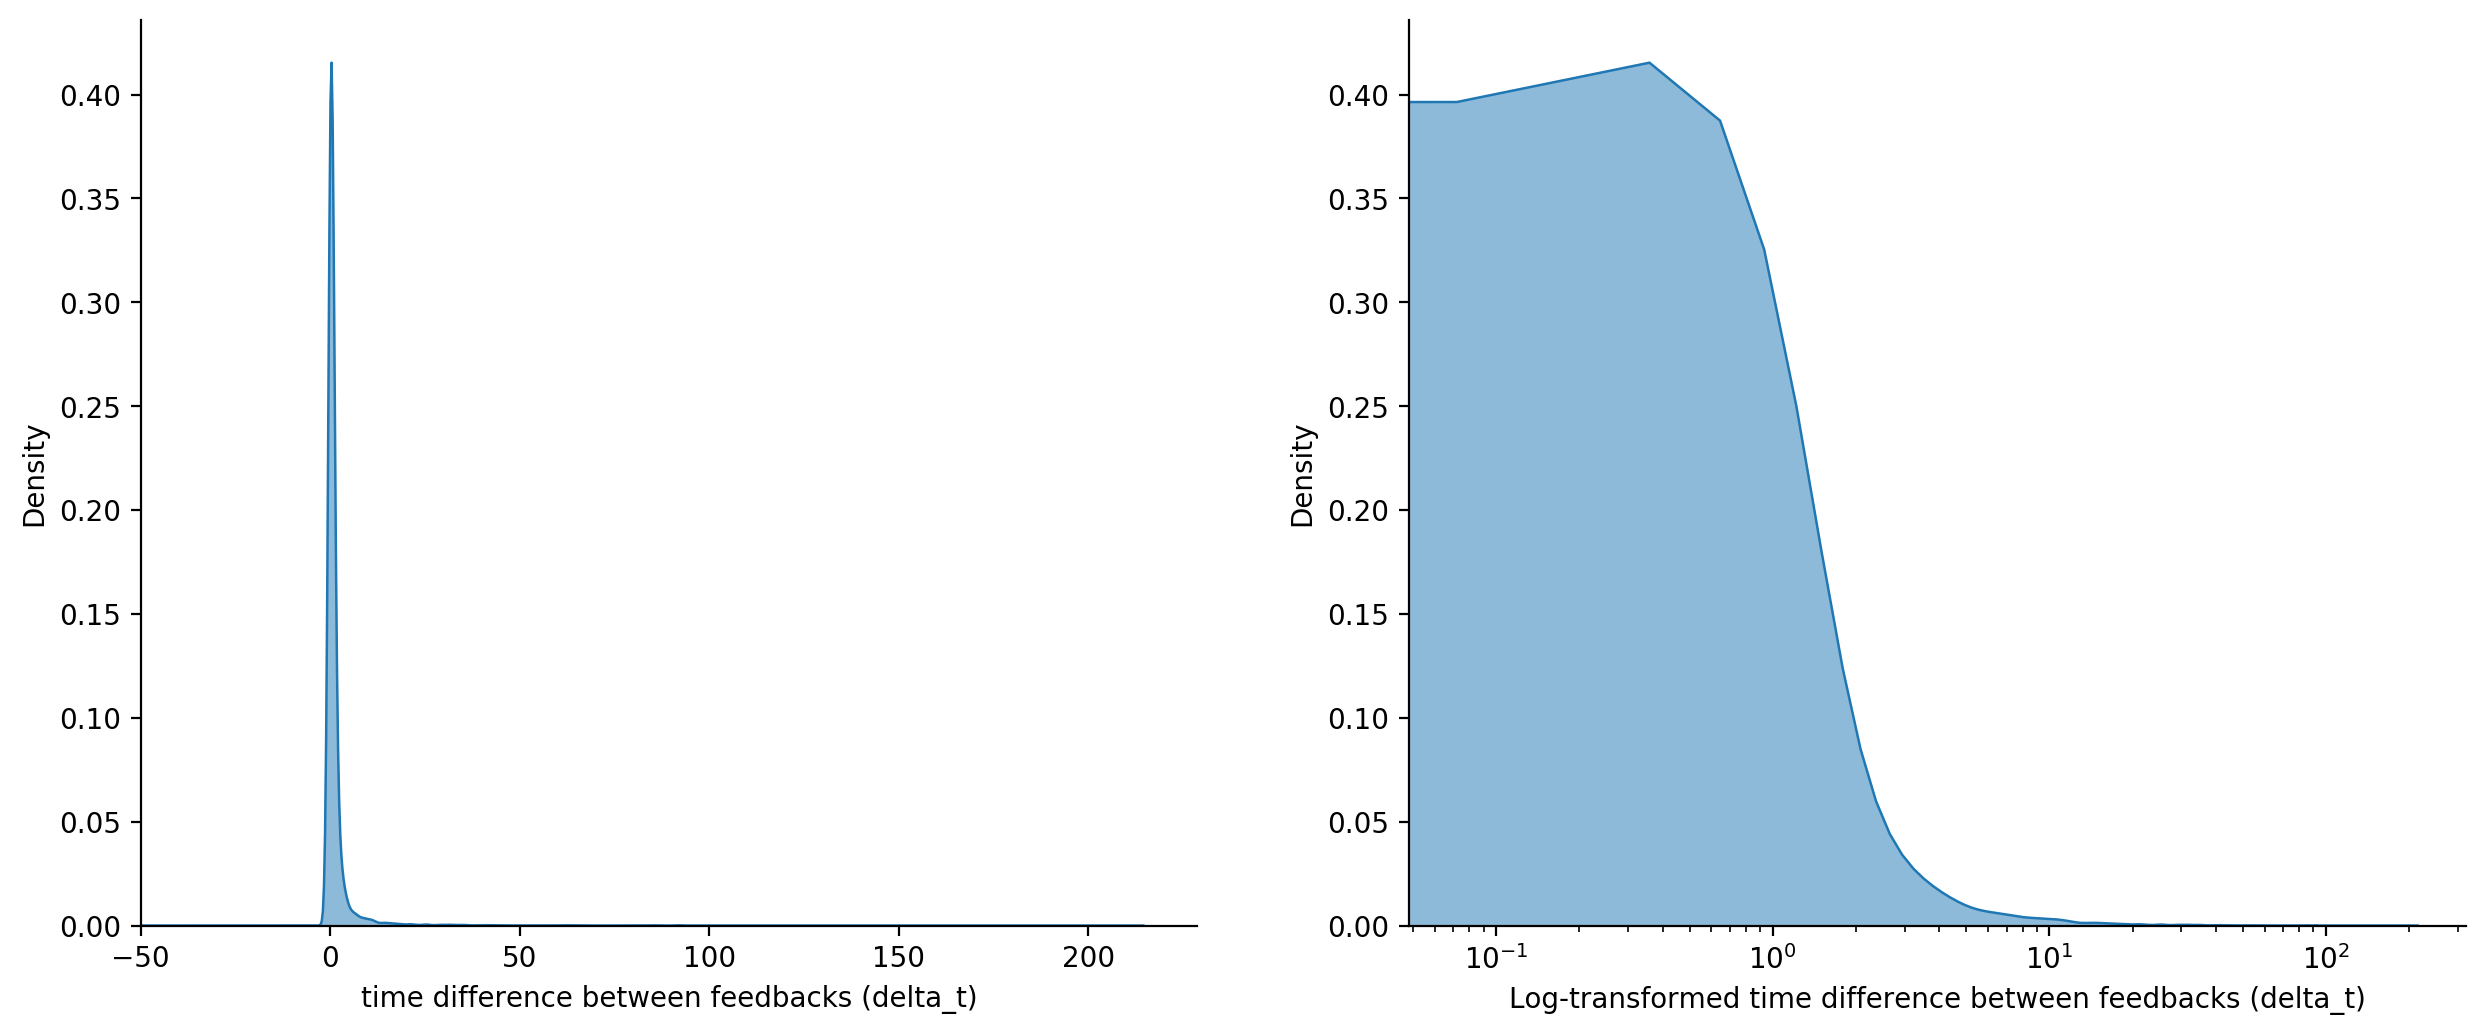

In [22]:
market_entry = (df['count'] <= 10) & (df['empty_stock'] == False)

# set plotting areas
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# make distribution plot w/o transformation (left)
df[market_entry]['delta_t'].plot.kde(ax = ax1, linewidth = .9)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# set axes
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = -50)
ax1.set(xlabel = 'time difference between feedbacks (delta_t)')

# make distribution plot with log transformation (right)
df[market_entry]['delta_t'].plot.kde(ax = ax2, linewidth = .9)
ax2.set_xscale('log')

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# set axes
ax2.set_ylim(bottom = 0)
ax2.set(xlabel = 'Log-transformed time difference between feedbacks (delta_t)')

plt.show()

The plots above present the density distributions of time difference between posted feedbacks. As expected, these distributions are extremely left skewed. **cut-off values need to be determined to excluded univariate outliers**

### Decision Rule for ARF

In [23]:
# setting cut of values
t_cut = df[market_entry]['delta_t'].quantile(1/3)
p_cut = df[market_entry]['price_usd'].quantile(1/3)
s_cut = df[market_entry].groupby('vendor')['delta_t'].std().quantile(1/3)

# drop existing column
if 'arf' in df: 
    df = df.drop('arf', axis = 1)

# ARF 1
col = df[market_entry]\
    .groupby('vendor')\
    .apply(lambda x: (x['delta_t'].median() < t_cut\
                      and (x['price_usd'].median() < p_cut)\
                      and (x['delta_t'].std() < s_cut)))\
    .rename('arf')

df = df.merge(col, on = 'vendor')

In [24]:
names = ['s_cut(entry)', 't_cut(entry)', 'p_cut(entry)']
cuts  = [ s_cut,   t_cut,   p_cut]

for n, c in zip(names, cuts):
    print(n, round(c, 3))

s_cut(entry) 0.076
t_cut(entry) 0.143
p_cut(entry) 75.923


In [25]:
len(df[df['arf'] == True]['vendor'].unique())

77

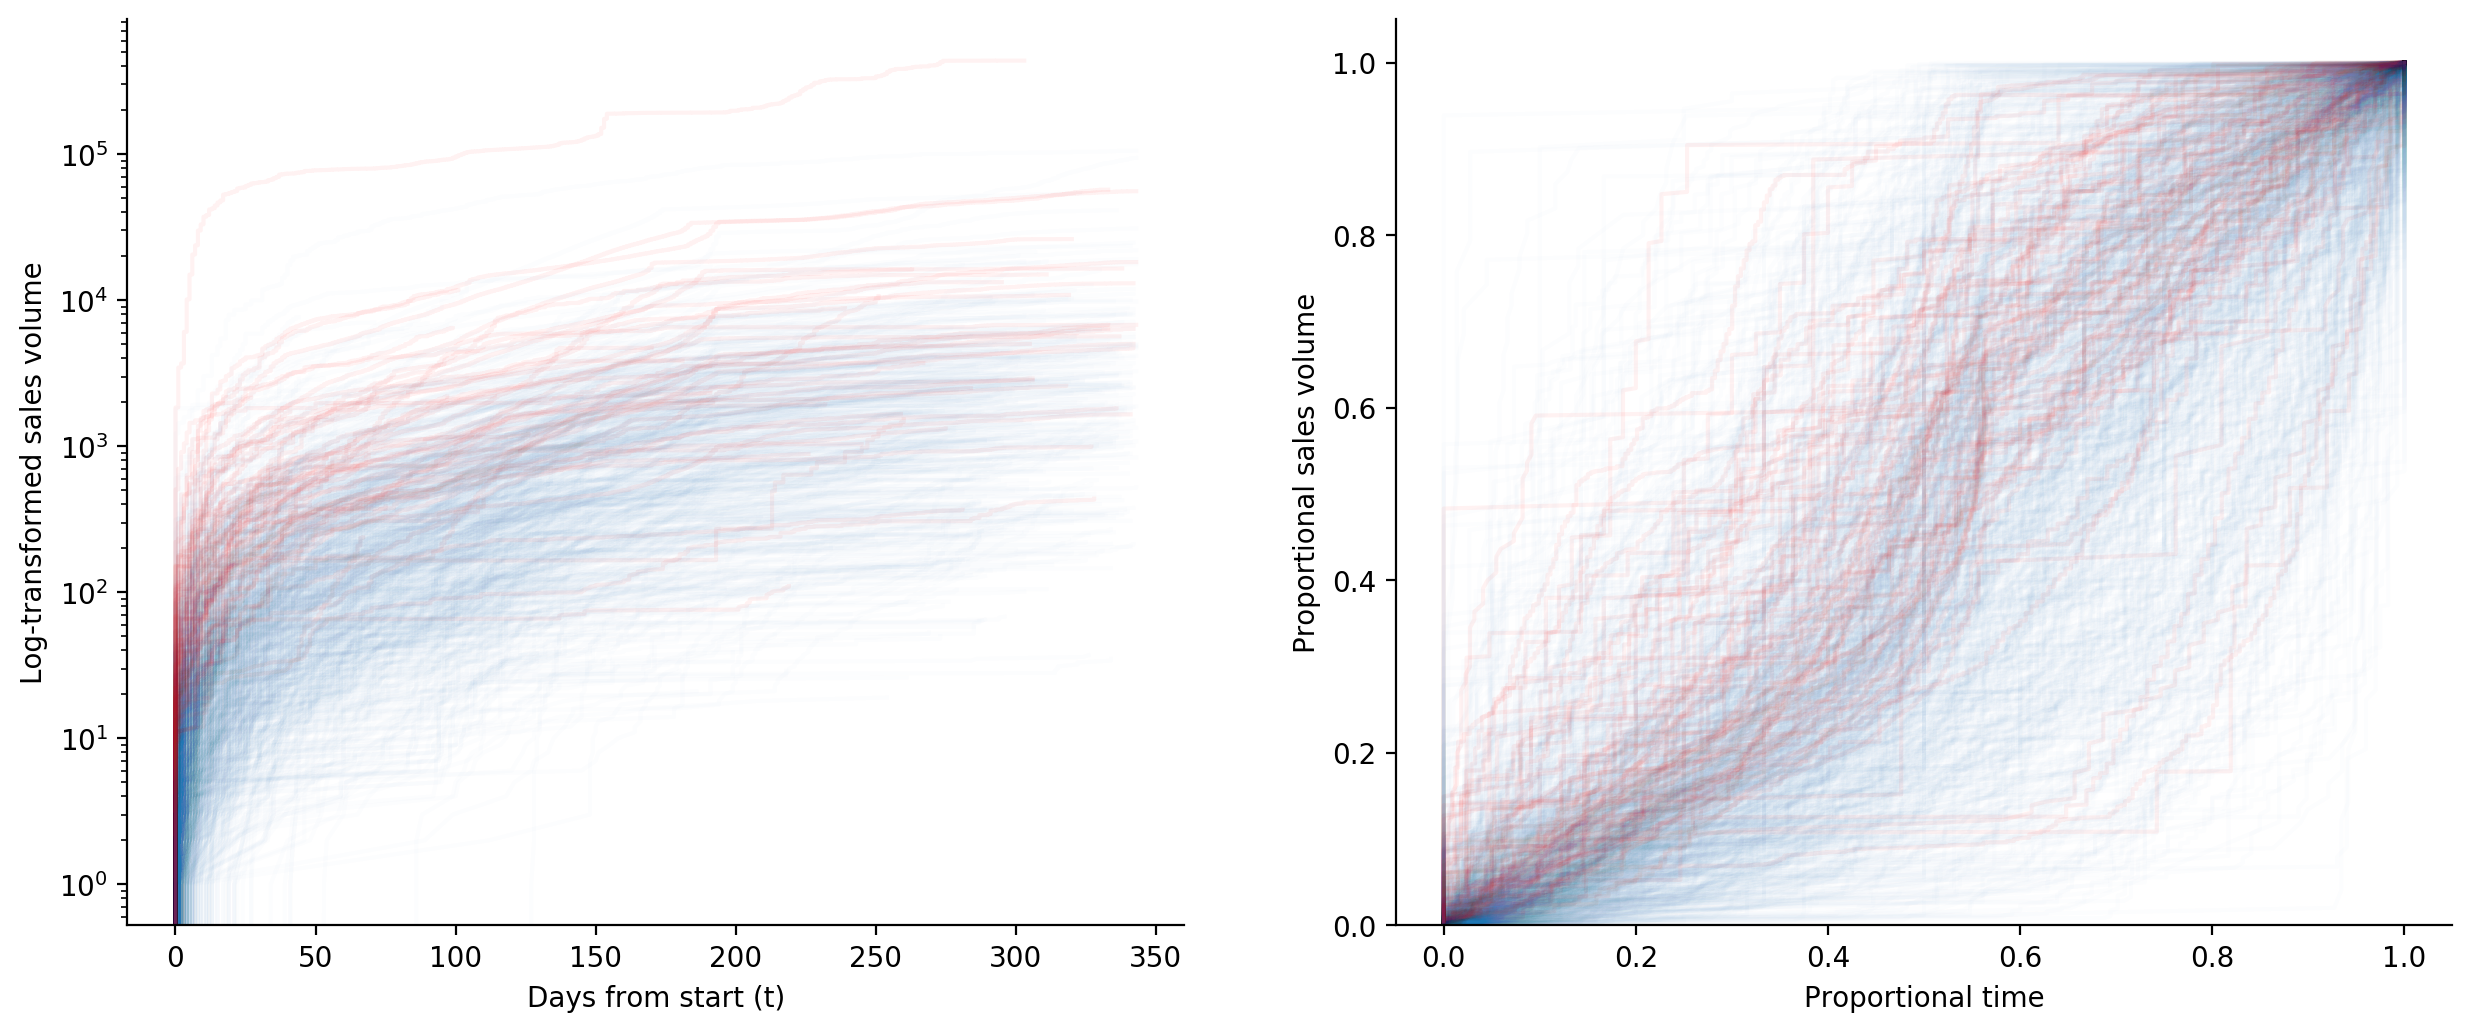

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# getting sellers that have had sufficient number of sales
df_ = df[df['cum_count'] >= 20]

vendors = df_['vendor'].unique().tolist()
colors = {True  : 'red',
          False : '#1f77b4'}
alphas = {True  : .05,
          False : .01}

# iterative plotting for sales trajectory of cryptosellers
for vendor in vendors:
    v = df_[df_['vendor'] == vendor][['count', 't', 'arf']].dropna()
    y = v['count'].astype(int).sort_values()
    x = v['t'].astype(int).sort_values()
    c = v['arf'].map(colors).to_list()[0]
    a = v['arf'].map(alphas).to_list()[0]
    
    # Plots sales trajectory 
    ax1.plot(x, y, alpha = a, c = c)
    ax1.set_yscale('log')
    ax1.set(xlabel = 'Days from start (t)',
            ylabel = 'Log-transformed sales volume')
    
    y = y / v['count'].max()
    x = x / v['t'].max()
    
    # Plots proportional sales trajectory
    ax2.plot(x, y, alpha = a, c = c)
    ax2.set_ylim(bottom = 0)
    ax2.set(xlabel = 'Proportional time',
            ylabel = 'Proportional sales volume')

# display plot
plt.show()

### Latent Class Analysis for ARF

In [27]:
std = df[df['count'] <= 10]\
    .reset_index(drop = True)\
    [['vendor', 't', 'delta_t']]\
    .groupby('vendor')\
    .std()\
    .add_suffix('_s')

mean = df[df['count'] <= 10]\
    .reset_index(drop = True)\
    [['vendor', 't', 'price_usd', 'delta_t']]\
    .groupby('vendor')\
    .mean()\
    .add_suffix('_m')

vendor_ = df[df['count'] <= 10]\
    [['vendor', 'arf']]\
    .groupby('vendor')\
    .mean()\
    .reset_index()
    
features = pd.concat([std, mean], axis = 1).reset_index(drop = True).fillna(0)
cols = features.columns

In [28]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler
from sklearn import mixture, cluster
from sklearn.neighbors import kneighbors_graph

# pre-processing
scaler = StandardScaler()
features = pd.DataFrame(
    scaler.fit_transform(power_transform(features, method = 'yeo-johnson')),
    columns = cols)

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    features, n_neighbors = 6, 
    include_self = False)
connectivity = 0.5 * (connectivity + connectivity.T)

# configure LCA algorithms
bgm = mixture.BayesianGaussianMixture(
    n_components = 2, 
    covariance_type = 'full')
birch = cluster.Birch(
    n_clusters = 2)
ward = cluster.AgglomerativeClustering(
    n_clusters = 2, 
    linkage ='ward',
    connectivity = connectivity)

# fit and predict results
arf_bgm = pd.Series(bgm.fit_predict(features), name = 'arf_bgm')
arf_birch = pd.Series(birch.fit_predict(features), name = 'arf_birch')
arf_ward = pd.Series(ward.fit_predict(features), name = 'arf_ward')

# concat results into a matrix
result = pd.concat([arf_bgm, arf_birch, arf_ward], axis = 1)

In [29]:
# assert 
result.sum()

arf_bgm      942
arf_birch    527
arf_ward     360
dtype: int64

In [30]:
if 'arf_bgm' in df: 
    df = df.drop(['arf_bgm', 'arf_birch', 'arf_ward'], axis = 1)

# merge result
df = df.merge(pd.concat([vendor_, result], axis = 1), on = ['vendor', 'arf'])\
    .assign(arf_bgm   = lambda x: x['arf_bgm'].map({1: False, 0: True}),
           arf_birch = lambda x: x['arf_birch'].map({0: False, 1: True}),
           arf_ward  = lambda x: x['arf_ward'].map({0: False, 1: True}))

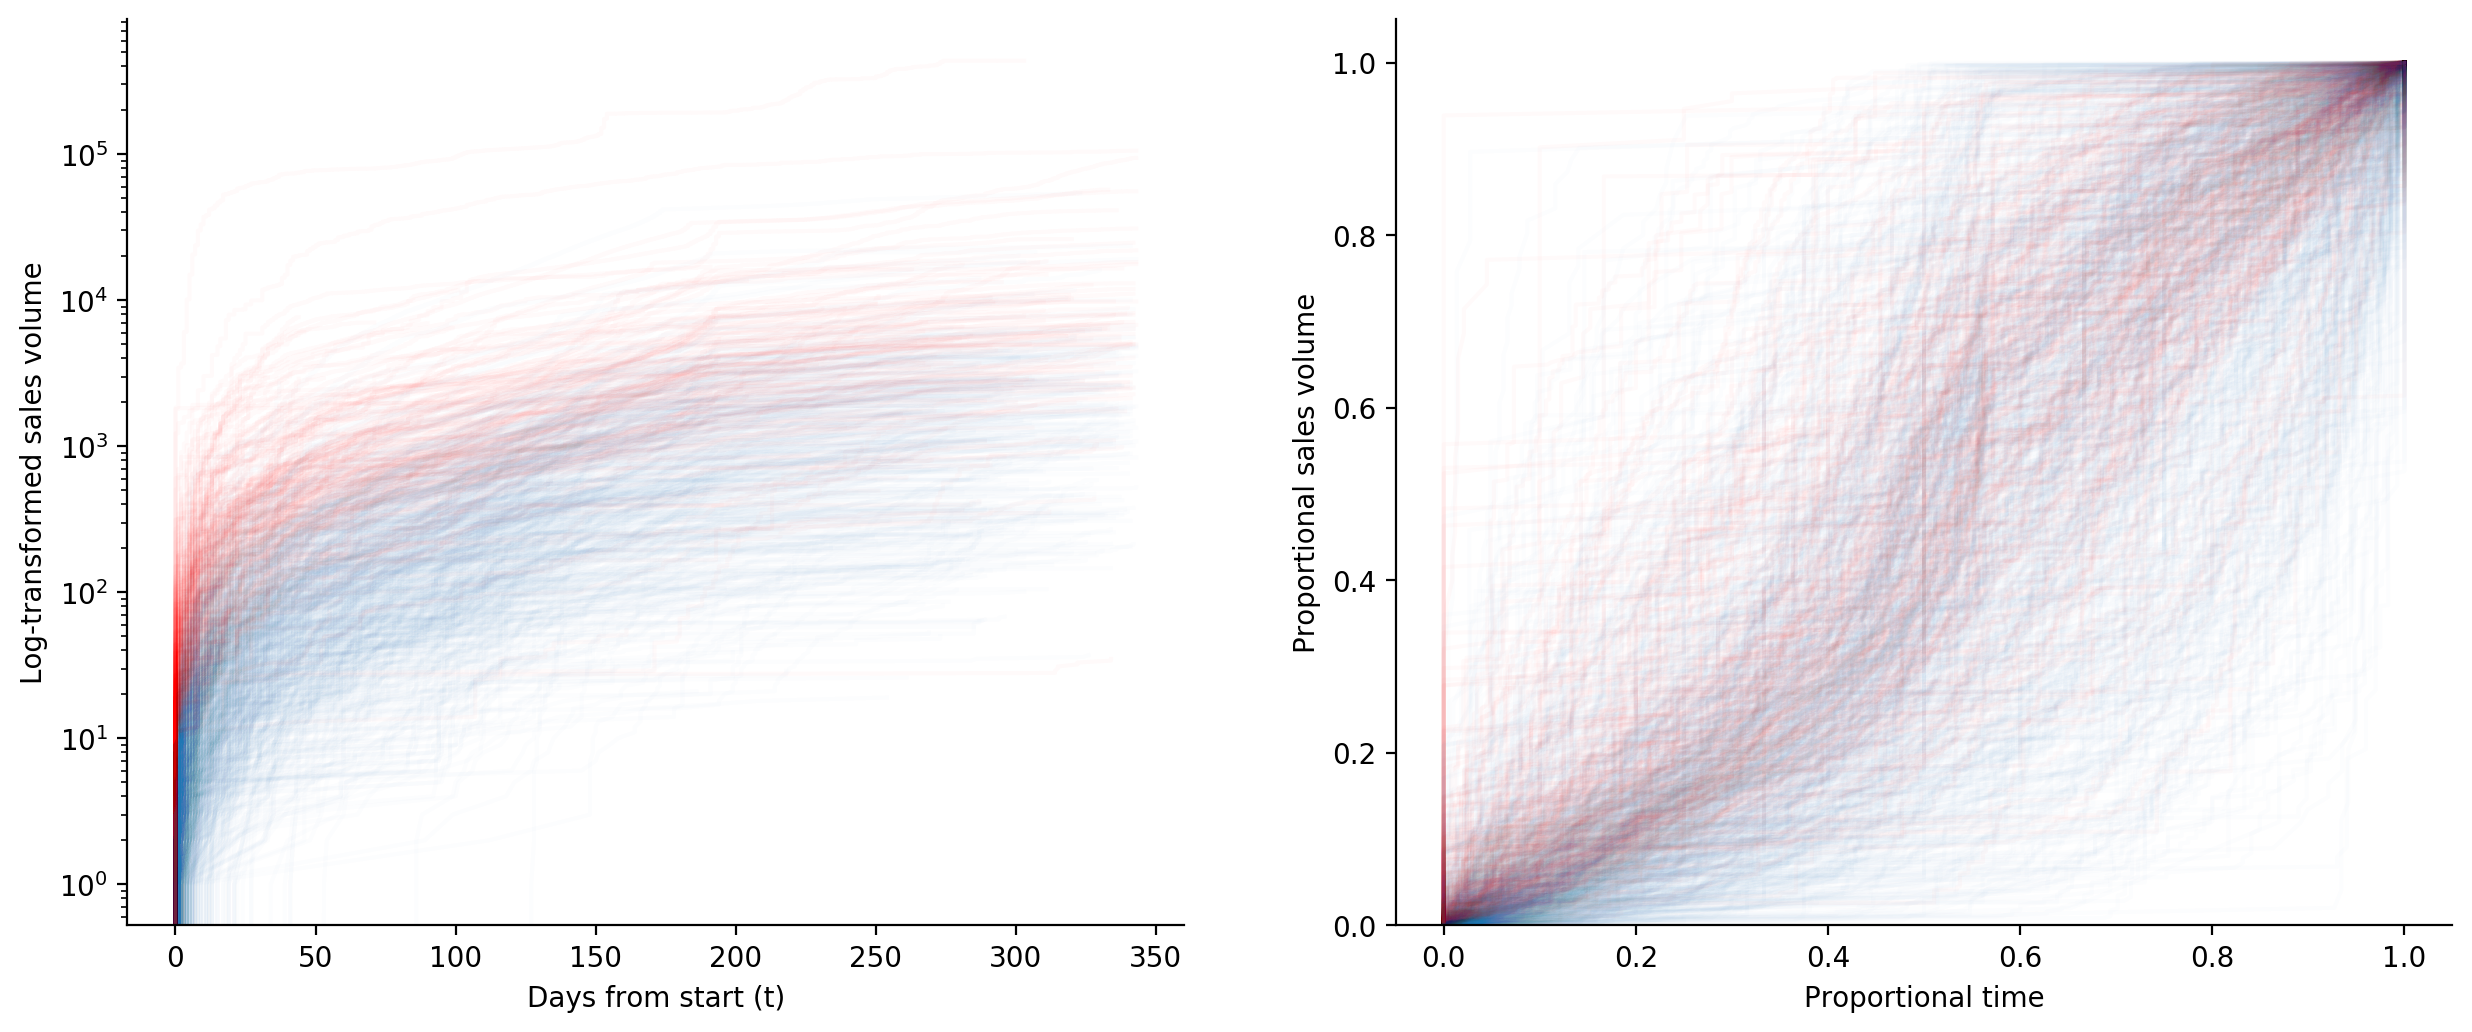

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# getting sellers that have had sufficient number of sales
df_ = df[df['cum_count'] >= 20]

vendors = df_['vendor'].unique().tolist()
colors = {True  : 'red',
          False : '#1f77b4'}
alphas = {True  : .02,
          False : .01}

# iterative plotting for sales trajectory of cryptosellers
for vendor in vendors:
    v = df_[df_['vendor'] == vendor][['count', 't', 'arf_bgm']].dropna()
    y = v['count'].astype(int).sort_values()
    x = v['t'].astype(int).sort_values()
    c = v['arf_bgm'].map(colors).to_list()[0]
    a = v['arf_bgm'].map(alphas).to_list()[0]
    
    # Plots sales trajectory 
    ax1.plot(x, y, alpha = a, c = c)
    ax1.set_yscale('log')
    ax1.set(xlabel = 'Days from start (t)',
            ylabel = 'Log-transformed sales volume')
    
    y = y / v['count'].max()
    x = x / v['t'].max()
    
    # Plots proportional sales trajectory
    ax2.plot(x, y, alpha = a, c = c)
    ax2.set_ylim(bottom = 0)
    ax2.set(xlabel = 'Proportional time',
            ylabel = 'Proportional sales volume')

# display plot
plt.show()

In [32]:
len(df[df['arf_bgm'] == True]['vendor'].unique())

290

## Negative Ratings

In [33]:
(df['rating'] == 5).mean()

0.9646871973930051

In [34]:
# in terms of expanding proportion of negative ratings
n_ = df\
    .sort_values('rtime')\
    .groupby('vendor')\
    .apply(lambda x : x['rating'] != 5)\
    .expanding(min_periods = 1).mean()\
    .reset_index(drop = True)\
    .rename('neg_rating')

# concat negative rating if not already concatted to dataframe
if 'neg_rating' not in df:
    df = pd.concat([df.sort_values('rtime'), n_], axis = 1)

In [35]:
df.sample(5)

vendor         stime   stime_dt  stime_str  rating  \
1810997        gotmilk  1.415179e+09 2014-11-05 2014-11-05       5   
2039950         pimpit  1.402431e+09 2014-06-10 2014-04-28       5   
2314760  profesorhouse  1.408750e+09 2014-08-22 2014-08-23       5   
638273        Litec0in  1.413159e+09 2014-10-13 2014-10-13       5   
149140          Bungee  1.402431e+09 2014-06-10 2014-05-19       5   

                                                  feedback  \
1810997  took about 3 weeks to get to USA but the adder...   
2039950  Arrived very fast to the EU, only 8 days. Stea...   
2314760                                  incredible vendor   
638273                                             Awesomw   
149140   Package never arrived but Bungee54 was easy to...   

                                                      item  \
1810997  Proviron - Bayer 25mg - 500 pills - $675 usd -...   
2039950  100x LSD Ffluff High Quality Xtal 250ug *PIMPI...   
2314760       drug - ! - How to Grow Psychedelic Mushrooms   
638273   All the Porn Passes you will ever need! *New S...   
149140     FE SPECIAL LISTING ** 10g MDMA SPECIAL PRICE **   

                                category     price  freshness  ...    t  \
1810997    drugs-steriodpeds-mesterelone  2.118264          1  ...  341   
2039950           drugs-psychedelics-LSD  1.958077         74  ...   86   
2314760  drugs-other-intoxicants-alcohol  0.036513          4  ...  223   
638273   drugs-other-intoxicants-alcohol  0.013838        148  ...   81   
149140                drugs-Ecstasy-mdma  0.555920         11  ...  183   

          count cum_count diff   delta_t    arf  arf_bgm  arf_birch  arf_ward  \
1810997   93303     94224  0.0  0.001024  False     True      False     False   
2039950     469      3895  0.0  0.111111  False    False       True     False   
2314760  268780    436934  0.0  0.000076   True     True      False     False   
638273     1244      3660  0.0  0.028571  False    False      False     False   
149140     3329      7087  1.0  0.010870  False     True       True     False   

         neg_rating  
1810997    0.037456  
2039950    0.038840  
2314760    0.036231  
638273     0.036726  
149140     0.045219  

[5 rows x 26 columns]

## Artificial Reputation Maintenance

In [36]:
not_market_entry = (df['count'] > 10) & (df['empty_stock'] == False)

# time fixed cut-offs
t_cut = df[not_market_entry]['delta_t'].quantile(1/3)
p_cut = df[not_market_entry]['price_usd'].quantile(1/3)
s_cut = df[not_market_entry].groupby('vendor')['delta_t'].std().quantile(1/3)

### Visual inspection of temporal fluctuation in cut-offs

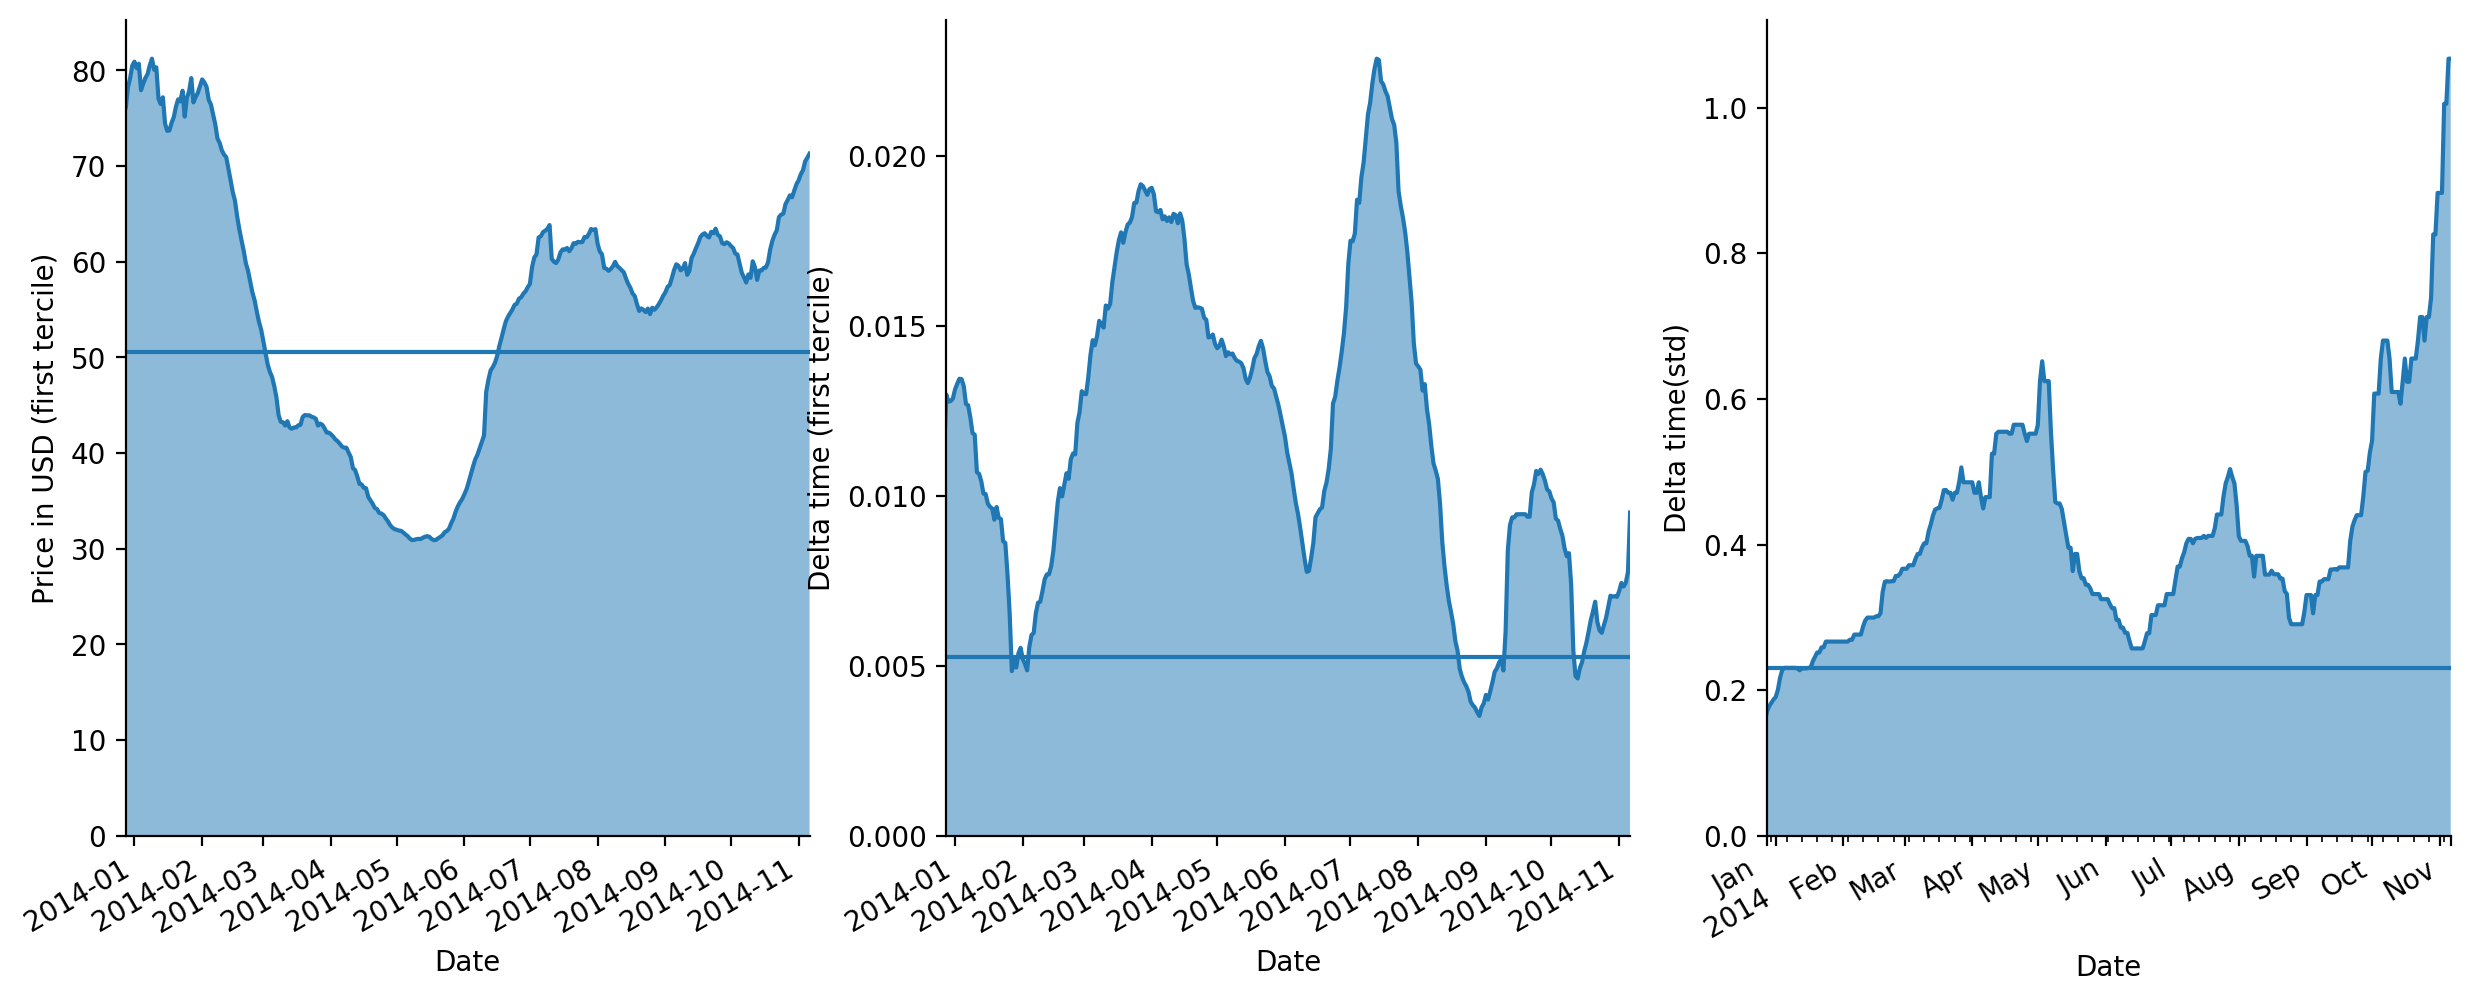

In [37]:
# offset minimum time
nt_min = t_min + pd.DateOffset(days = 30)

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = [15,6])

# plot price fluctuation over time (left)
df[not_market_entry]\
    .groupby(df['rtime_dt'].dt.date)['price_usd']\
    .quantile(1/3)\
    .rolling(30)\
    .mean().plot(ax = ax1)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# horizontal lines
ax1.axhline(y = p_cut)

# set axes
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = nt_min, right = t_max)
ax1.set(xlabel = 'Date',
        ylabel = 'Price in USD (first tercile)')

# plot delta_t fluctuations over time (middle)
df[not_market_entry]\
    .groupby(df['rtime_dt'].dt.date)['delta_t']\
    .quantile(1/3)\
    .rolling(30)\
    .mean().plot(ax = ax2)

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# horizontal line
ax2.axhline(y = t_cut)

# set axes
ax2.set_ylim(bottom = 0)
ax2.set_xlim(left = nt_min, right = t_max)
ax2.set(xlabel = 'Date',
        ylabel = 'Delta time (first tercile)')

# plot delta_t fluctuations over time (middle)
df[not_market_entry]\
    .groupby(df['rtime_dt'].dt.normalize())['delta_t']\
    .std()\
    .rolling(30)\
    .quantile(1/3).plot(ax = ax3)

# fill graph
line = ax3.lines[0].get_data()
ax3.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# horizontal line
ax3.axhline(y = s_cut)

# set axes
ax3.set_ylim(bottom = 0)
ax3.set_xlim(left = nt_min, right = t_max)
ax3.set(xlabel = 'Date',
        ylabel = 'Delta time(std)')

fig.autofmt_xdate()
plt.show()

The plots above show the temporal variation in price (first tercile) and time (first quartile) cut-offs. The plots indicate that there are considerably fluctuations in both price and time gaps during market entry over time. The temporal differences in time gaps are to be interpreted in the light of increases and decreases of demand and supply. 

In conclusion to the visual inspection of the temporal differences in time and price cut-offs over time we deem that the time constant cut-offs suffice.

### Decision Rule for ARM

In [38]:
# sort data frame
df = df.sort_values(['vendor', 'rtime']).reset_index(drop = True)

# calculate ARM
df['arm'] = df\
    .groupby(['vendor'])\
    [['delta_t', 'price_usd', 'rating', 'count']]\
    .rolling(10)\
    .mean()\
    .reset_index()\
    .assign(t_low = lambda x: x['delta_t'] < t_cut,
            p_low = lambda x: x['price_usd'] < p_cut,
            after_market_entry = lambda x: x['count'] > 10)\
    .assign(arm = lambda x: (x[['t_low', 'p_low', 'after_market_entry']].all(axis = 1)))['arm']

In [39]:
df.loc[df['count'] <= 10, 'arm'] = None

In [40]:
print(df['arm'].value_counts())

0.0    2623383
1.0     218995
Name: arm, dtype: int64


### Latent Class Analysis for ARM

In [41]:
df = df.sort_values(['vendor', 'count']).reset_index()

std = df[df['count'] > 10]\
    .reset_index(drop = True)\
    [['vendor', 't', 'delta_t']]\
    .groupby('vendor')\
    .rolling(10, min_periods = 1)\
    .std()\
    .fillna(0)\
    .add_suffix('_s')

mean = df[df['count'] > 10]\
    .reset_index(drop = True)\
    [['vendor', 't', 'price_usd', 'delta_t']]\
    .groupby('vendor')\
    .rolling(10, min_periods = 1)\
    .mean()\
    .add_suffix('_m')

vendor_ = df[df['count'] > 10]\
    [['vendor', 'arm']]\
    .reset_index()
    
features = pd.concat([std, mean], axis = 1)\
    .reset_index(drop = True)\
    .drop(['vendor_s', 'vendor_m'], axis = 1)\
    .dropna()
cols = features.columns

In [42]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler
from sklearn import mixture, cluster
from sklearn.neighbors import kneighbors_graph

# pre-processing
scaler = StandardScaler()
features = pd.DataFrame(
    scaler.fit_transform(power_transform(features, method = 'yeo-johnson')),
    columns = cols)

In [43]:
# configure LCA algorithm
bgm = mixture.BayesianGaussianMixture(
    n_components = 2, 
    covariance_type = 'full')

# fit results
bgm = bgm.fit(features)

# predict results
arm_bgm = pd.Series(bgm.fit_predict(features), name = 'arm_bgm')

In [44]:
arm_bgm.sum()

761711

In [45]:
result = pd.concat([vendor_, arm_bgm], axis = 1)\
    .assign(arm_bgm = lambda x: x['arm_bgm'].map({1: False, 0: True}))\
    .set_index('index')\
    .drop(['vendor', 'arm'], axis = 1)

In [46]:
if 'arm_bgm' in df: 
    df = df.drop('arm_bgm', axis = 1)

# merge result
df = pd.concat([df, result], axis = 1)

In [47]:
df.sample(5)

index           vendor         stime   stime_dt  stime_str  rating  \
559970    560047  Holland-Kitchen  1.408922e+09 2014-08-24 2014-08-27       5   
2068027  2066689    profesorhouse  1.408580e+09 2014-08-21 2014-08-23       5   
2148515  2148449    profesorhouse  1.402430e+09 2014-06-10 2014-03-03       5   
162268    162267   CaptainChronic  1.410232e+09 2014-09-09 2014-09-10       5   
891845    891863          Quixote  1.402431e+09 2014-06-10 2014-05-19       5   

                                                  feedback  \
559970                                        Always great   
2068027  Item came quickly, with an awesome bonus! Can'...   
2148515        One of the best Ebooks I have ever written,   
162268                      Good as always, Thanks Captain   
891845   Hands down the best customer service I've ever...   

                                                      item  \
559970   FREE 5g Sample of Pharma Grade Speed Paste - B...   
2068027  Learn a Ultimate CA$H KING Exploits! - $320 In...   
2148515    Getting Started With Arduino A Beginner’s Guide   
162268               Pineapple Express 1/8 ounce 3.5 grams   
891845       OxyContin (Oxycodone) 40mg Tablets x3 [OC40s]   

                                        category     price  ...  cum_count  \
559970                    drugs-stimulants-speed  0.105000  ...       7642   
2068027                                    books  0.915166  ...     436934   
2148515          drugs-other-intoxicants-alcohol  0.019255  ...     436934   
162268                            drugs-cannabis  0.096849  ...       1837   
891845   drugs-prescription-analgesics-oxycodone  0.238723  ...       4984   

         diff   delta_t    arf arf_bgm  arf_birch  arf_ward  neg_rating  arm  \
559970    0.0  0.006061  False    True       True     False    0.035561  0.0   
2068027   0.0  0.000313   True    True      False     False    0.038435  0.0   
2148515   0.0  0.000737   True    True      False     False    0.037500  0.0   
162268    0.0  0.166667  False   False      False     False    0.044328  0.0   
891845    0.0  0.030303  False    True      False     False    0.033066  0.0   

         arm_bgm  
559970      True  
2068027     True  
2148515     True  
162268     False  
891845     False  

[5 rows x 29 columns]

## Market Exit

In [48]:
# getting sellers that have had sufficient number of sales
df_ = df.copy()

col = df_.t\
    .groupby(df_.vendor)\
    .apply(lambda x: int(x.max()))\
    .reset_index()\
    .rename(columns = {'t': 'last_sale'})

In [49]:
df_ = pd.merge(df_, col, on = 'vendor')

In [50]:
vendors = df_[['vendor', 'arf', 'last_sale', 'stime_str']]\
    .drop_duplicates()\
    .reset_index(drop = True)\
    .assign(exit = lambda x: x['stime_str'] != x['stime_str'].max())\
    .drop('stime_str', axis = 1)\
    .drop_duplicates(keep = 'last')\
    .reset_index(drop = True)

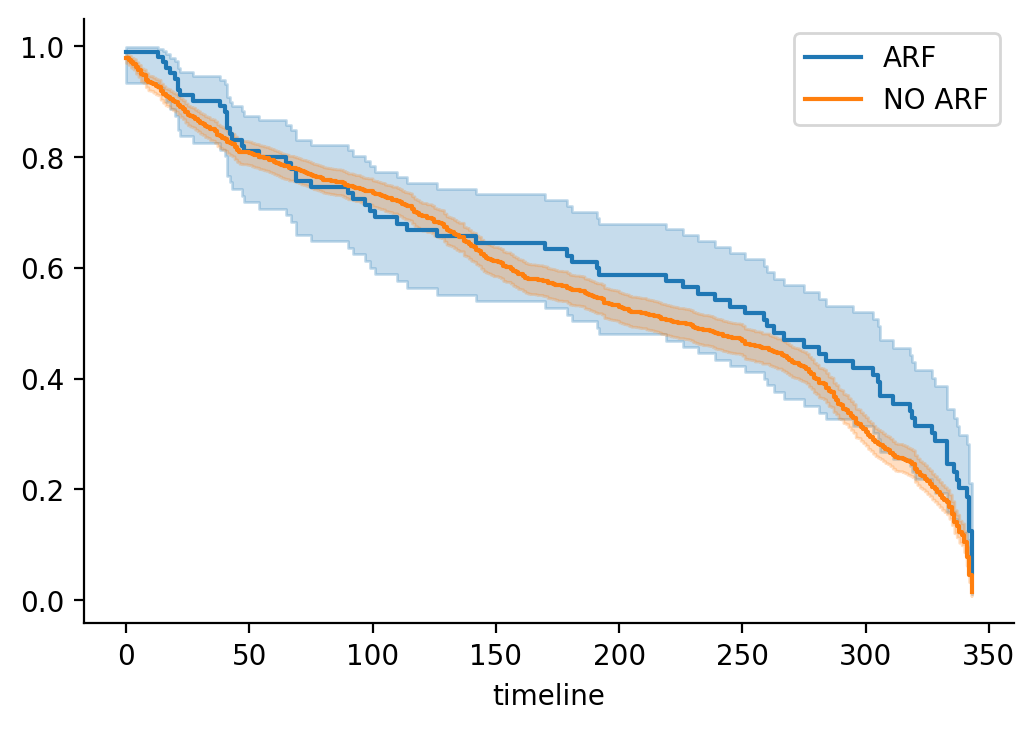

In [51]:
from lifelines import KaplanMeierFitter

# set groups
did_arf = (vendors['arf'] == True)
no_arf = (vendors['arf'] == False)

# plot for ARF sellers
kmf = KaplanMeierFitter()
kmf.fit(durations=vendors.last_sale[did_arf],
        event_observed=vendors.exit[did_arf],
        label='ARF',)
a1 = kmf.plot()

# plot for no_ARF sellers
kmf.fit(durations=vendors.last_sale[no_arf],
        event_observed=vendors.exit[no_arf],
        label='NO ARF',)
a1 = kmf.plot(ax=a1)

plt.show()

In [52]:
# subset = ['vendor', 'flag', 'location', 'feedback', 'rating']

# # merge 
# df = pd.merge(df, 
#         vendors, 
#         on = ['vendor', 'arf_2'],
#         how = 'inner')\
#     .assign(flag = df.rtime_dt.dt.date.astype('category'))\
#     .drop_duplicates(subset = subset)\
#     .drop('flag', axis = 1)

In [53]:
# del df_, vendors, a1, subset

## Selling Price adjustment

In [54]:
# drop existing column    
if 'empty_stock_yesterday' in df: 
    df = df.drop('empty_stock_yesterday', axis = 1)

# construct variable indicating an empty stock yesterday
empty_stock_yesterday = df\
    .groupby(['item', 'rtime_dt'])['empty_stock']\
    .max()\
    .reset_index()\
    .groupby('item')\
    .apply(lambda x: x['empty_stock'].shift(1))\
    .bfill()\
    .reset_index(drop = True)\
    .rename('empty_stock_yesterday')

# merge price drops of items per day in data frame
i_ = df[['item', 'rtime_dt']]\
    .drop_duplicates().reset_index(drop = True)

df = pd.merge(df, 
         pd.concat([i_, empty_stock_yesterday], axis = 1),
         on = ['item', 'rtime_dt'])

In [72]:
# drop existing column
if 'price_diff' in df: 
    df = df.drop('price_diff', axis = 1)

# drop existing column    
if 'has_price_drop' in df: 
    df = df.drop('has_price_drop', axis = 1)

# construct price drop column in USD
price_diff = df\
    .groupby(['item', 'rtime_dt'])['price_usd']\
    .mean()\
    .reset_index()\
    .groupby('item')\
    .apply(lambda x: ((x['price_usd'] / x['price_usd'].shift(1))))\
    .reset_index(drop = True)\
    .fillna(1)\
    .rename('price_diff')

# merge price drops of items per day in data frame
i_ = df[['item', 'rtime_dt']]\
    .drop_duplicates().reset_index(drop = True)
df = pd.merge(df, 
         pd.concat([i_, price_diff], axis = 1),
         on = ['item', 'rtime_dt'])

diff_cut = df['price_diff'].quantile(.10)

# make boolean stating that seller has price drop
df = df.assign(has_price_drop = df['price_diff'] <= diff_cut)

In [75]:
df.loc[(df['empty_stock_yesterday'] == True), 'has_price_drop'] = False
df.loc[(df['price_diff'].isin([np.nan, np.inf, -np.inf])), 'has_price_drop'] = None
df['has_price_drop'].mean()

0.09600903654019596

# Data Summary

In [ ]:
# valid_range = (~df['price_usd'].isin([np.nan, np.inf, -np.inf]))\
#             & (df['price_usd'] >= 0)

# df['price_usd'] = df['price_usd'].mask(~valid_range)

# valid_range = (~df['price'].isin([np.nan, np.inf, -np.inf]))\
#             & (df['price'] > 0)

# df['price'] = df['price'].mask(~valid_range)

In [77]:
df[['arf', 'neg_rating', 'has_price_drop', 'arm', 't', 'vendor']]\
    .assign(
        arf_1 = df['arf'].astype('float'),
        price_usd_drop = df['has_price_drop'].astype('float'),
        arm = df['arm'].astype('float')
    )\
    .describe()\
    .applymap('{:.3f}'.format)\
    .T[['mean', 'std', 'min', 'max']]

mean     std    min      max
neg_rating        0.036   0.004  0.000    0.400
has_price_drop    0.096   0.295  0.000    1.000
arm               0.077   0.267  0.000    1.000
t               155.669  87.190  0.000  343.000
arf_1             0.290   0.454  0.000    1.000
price_usd_drop    0.096   0.295  0.000    1.000

In [67]:
df.shape[0]

2855395

In [64]:
df['item'].nunique()

28915

In [68]:
df['vendor'].nunique()

1232

In [69]:
df[df['empty_stock'] == False].describe()\
    .applymap('{:.4f}'.format)\
    .T[['count', 'mean', 'std', 'min', 'max']]

count             mean           std              min  \
index       2796634.0000     1433011.3562   824446.7236           0.0000   
stime       2796634.0000  1407136000.0000  4614626.0000  1393133824.0000   
rating      2796634.0000           4.9052        0.5540           1.0000   
price       2796634.0000           0.9114        2.2084           0.0000   
freshness   2796634.0000          51.5923       72.2918           0.0000   
rtime       2796634.0000  1402678144.0000  7295793.5000  1385597056.0000   
price_usd   2796634.0000         483.5686     1131.5760           0.0000   
t           2796634.0000         155.9308       86.9840           0.0000   
count       2796634.0000       42332.1365    92088.2054           0.0000   
cum_count   2796634.0000       84586.1710   153720.1949           1.0000   
diff        2796634.0000           0.0786        1.0124           0.0000   
delta_t     2796634.0000           0.0786        0.8166           0.0000   
neg_rating  2796634.0000           0.0362        0.0035           0.0000   
arm         2783992.0000           0.0786        0.2691           0.0000   
price_diff  2796634.0000              inf           nan           0.0000   

                        max  
index          2855394.0000  
stime       1422118912.0000  
rating               5.0000  
price               31.5000  
freshness          343.0000  
rtime       1415293312.0000  
price_usd         9999.4050  
t                  343.0000  
count           436933.0000  
cum_count       436934.0000  
diff               299.0000  
delta_t            212.0000  
neg_rating           0.4000  
arm                  1.0000  
price_diff              inf

In [ ]:
df.isna().sum()